In [1]:
# import scanpy as sc
# import pandas as pd 
# import numpy as np
# from scipy.sparse import csr_matrix
# import matplotlib.pyplot as plt



# #from nero import Harmonia
# from tqdm import tqdm_notebook as tqdm
# import warnings
# import itertools as it
# import pickle as pkl
# from copy import copy

# import matplotlib.patches as patches
# from shapely.geometry import Point
# from shapely.geometry.polygon import Polygon

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
import numpy as np

import scanpy as sc
import scipy
import warnings
from tqdm.notebook import tqdm
import pickle as pkl
from matplotlib.patches import Polygon

import matplotlib as mpl
import seaborn as sns

In [3]:
# might need this, the most recent version of jupterlab I installed installed the most recent version of jedi which has been having problems with autocomplete
# see thread here: https://github.com/ipython/ipython/issues/10493
%config Completer.use_jedi = False
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80)

## Reading in Data

In [4]:
exps = dict()
for exp in range(5):
    exps[exp] = dict()

In [5]:
exps[0]['path'] = '../../../../data/h5_data/20180831_L10C.h5ad'
exps[1]['path'] = '../../../../data/h5_data/20190920_L20C1.h5ad'
exps[2]['path'] = '../../../../data/h5_data/20190920_L20T.h5ad'
exps[3]['path'] = '../../../../data/h5_data/20180831_L30C.h5ad'
exps[4]['path'] = '../../../../data/h5_data/20180831_L30C8.h5ad'

In [6]:
for exp in exps:
    exps[exp]['adata'] = sc.read_h5ad(exps[exp]['path'])

In [7]:
for exp in exps:
    exps[exp]['label'] = exps[exp]['path'].split('/')[-1]

## Filtering for Cells, Labeling Human and Mouse Cells

In [8]:
adata = exps[0]['adata'].concatenate(exps[1]['adata'],exps[2]['adata'],exps[3]['adata'],exps[4]['adata'], join='inner').copy()

In [9]:
###################################################################################################

In [10]:
adata

AnnData object with n_obs × n_vars = 72981 × 121472
    obs: 'batch'

In [11]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)

adata.obs['log_counts'] = np.log(adata.obs['n_counts'])

adata.obs['n_genes'] = (adata.X > 0).sum(1)

In [12]:
adata.obs['barcode'] = adata.obs.index.str[-18:-2]

In [13]:
adata.var_names_make_unique()

In [14]:
#sc.pl.highest_expr_genes(adata, n_top=100) 

In [15]:
mito_genes_mouse=[name for name in adata.var_names if name.startswith(('mm10_mt-'))]
                                                              
#mito_genes_human=[name for name in adata.var_names if name.startswith(('hg19_MT-'))] 

adata.obs['percent_mito_mouse'] = np.sum(adata[:, mito_genes_mouse].X, axis=1) / np.sum(adata.X, axis=1)*100

#adata.obs['percent_mito_human'] = np.sum(adata[:, mito_genes_human].X, axis=1) / np.sum(adata.X, axis=1)*100

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [16]:
sc.pp.filter_cells(adata, min_counts = 500)

filtered out 53144 cells that have less than 500 counts


In [17]:
sc.pp.filter_cells(adata, min_genes = 100)

filtered out 176 cells that have less than 100 genes expressed


In [18]:
sc.pp.filter_genes(adata, min_cells=1)

filtered out 66126 genes that are detected in less than 1 cells


In [19]:
adata.var['log_cells']=np.log10(adata.var['n_cells'])

In [20]:
adata = adata[adata.obs['n_counts'] < 10000, :]

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [21]:
adata = adata[adata.obs['percent_mito_mouse'] < 1, :]

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [22]:
#barnyard


mouse_genes=[name for name in adata.var_names if name.startswith('mm10_')]
#human_genes=[name for name in adata.var_names if name.startswith('GRCh38_')]

human_genes=[name for name in adata.var_names if name.startswith('hg19')]


adata.obs['mouse_counts'] = np.sum(adata[:, mouse_genes].X, axis=1)
adata.obs['human_counts'] = np.sum(adata[:, human_genes].X, axis=1)

Trying to set attribute `.obs` of view, copying.


In [24]:
cmap = mpl.colors.ListedColormap(['royalblue','lightgrey', 'orangered'])

np.seterr(divide = 'ignore') 
adata.obs['ratio'] = np.log10(np.true_divide(adata.obs['mouse_counts'], adata.obs['human_counts']))


def cell_call(counts):
        if counts['ratio'] > 0.66:
                return 'M'
        elif counts['ratio'] < -0.66:
                return 'H'
        else:
                return 'C'

         
adata.obs['cell_call']=adata.obs.apply(lambda counts: cell_call(counts), axis=1)



In [25]:
adata_m = adata[adata.obs.cell_call == 'M']

In [26]:
#adata_m.raw = adata_m

In [27]:
adata_m.raw = sc.pp.log1p(adata_m, copy=True)

In [28]:
sc.pp.normalize_per_cell(adata_m, counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


extracting highly variable genes
    finished (0:00:00)


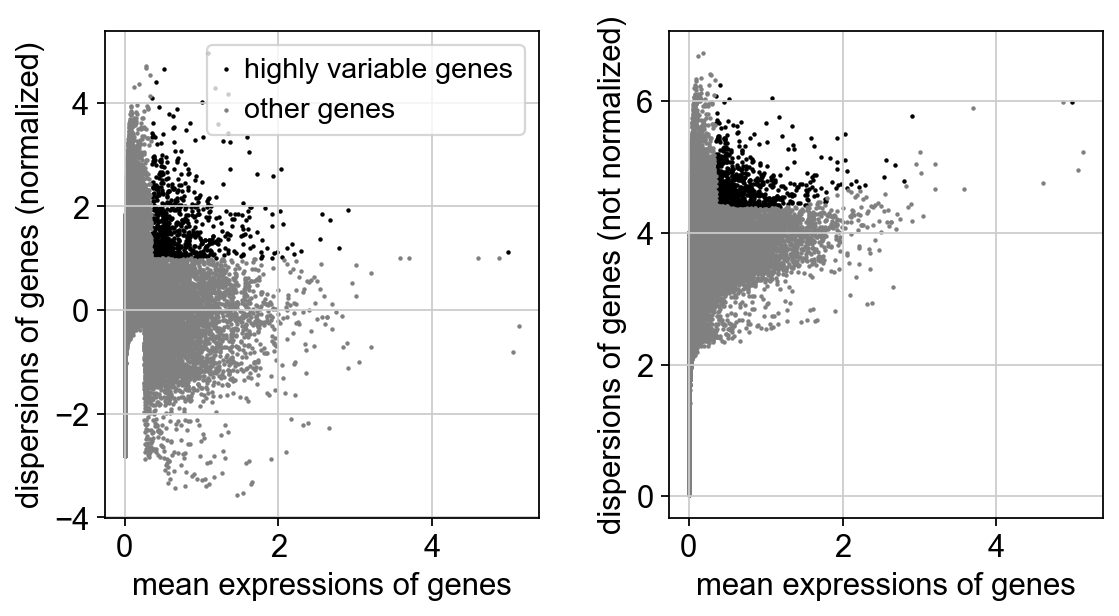

In [29]:
filter_result = sc.pp.filter_genes_dispersion(
    adata_m.X,
#     n_top_genes=2000
    min_mean=0.35,
    max_mean=7,
    min_disp=1
                                            ) 


####L20C1 parameters 

sc.pl.filter_genes_dispersion(filter_result)

In [30]:
adata_m = adata_m[:, filter_result.gene_subset]

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [31]:
sc.pp.log1p(adata_m)

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [32]:
#Regress out unwanted sources of variation
sc.pp.regress_out(adata_m, ['n_counts',
#                           'percent_mito_human',
#                           'percent_mito_mouse',
              #            'percent_contam'
                         ])

regressing out ['n_counts']
    sparse input is densified and may lead to high memory use


/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'barcode' as categorical
... storing 'cell_call' as categorical


    finished (0:00:03)


In [33]:
sc.pp.scale(adata_m, max_value=10)

In [34]:
sc.tl.pca(adata_m,
          svd_solver='arpack'
         )

computing PCA
    with n_comps=50
    finished (0:00:00)


In [35]:
sc.tl.tsne(adata_m,
           n_pcs=13,
        #    early_exaggeration=10
          )

computing tSNE
    using 'X_pca' with n_pcs = 13
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:34)


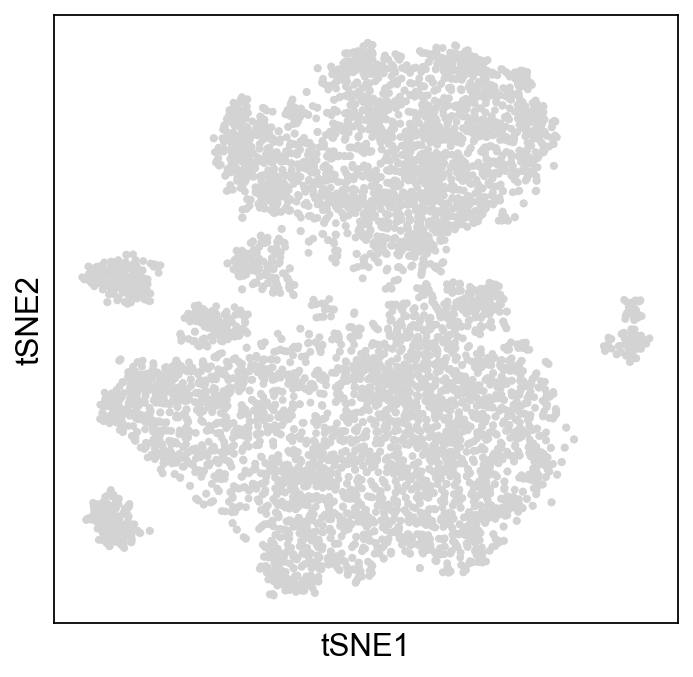

In [36]:
plt.rcParams['figure.figsize'] = [5, 5]

sc.pl.tsne(adata_m,
           ncols=1,
           palette='tab10',
           
           size=50
          )

In [37]:
sc.pp.neighbors(adata_m, 
                n_neighbors=10,
                n_pcs=15)

computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


In [38]:
sc.tl.leiden(adata_m, resolution=0.5)

running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


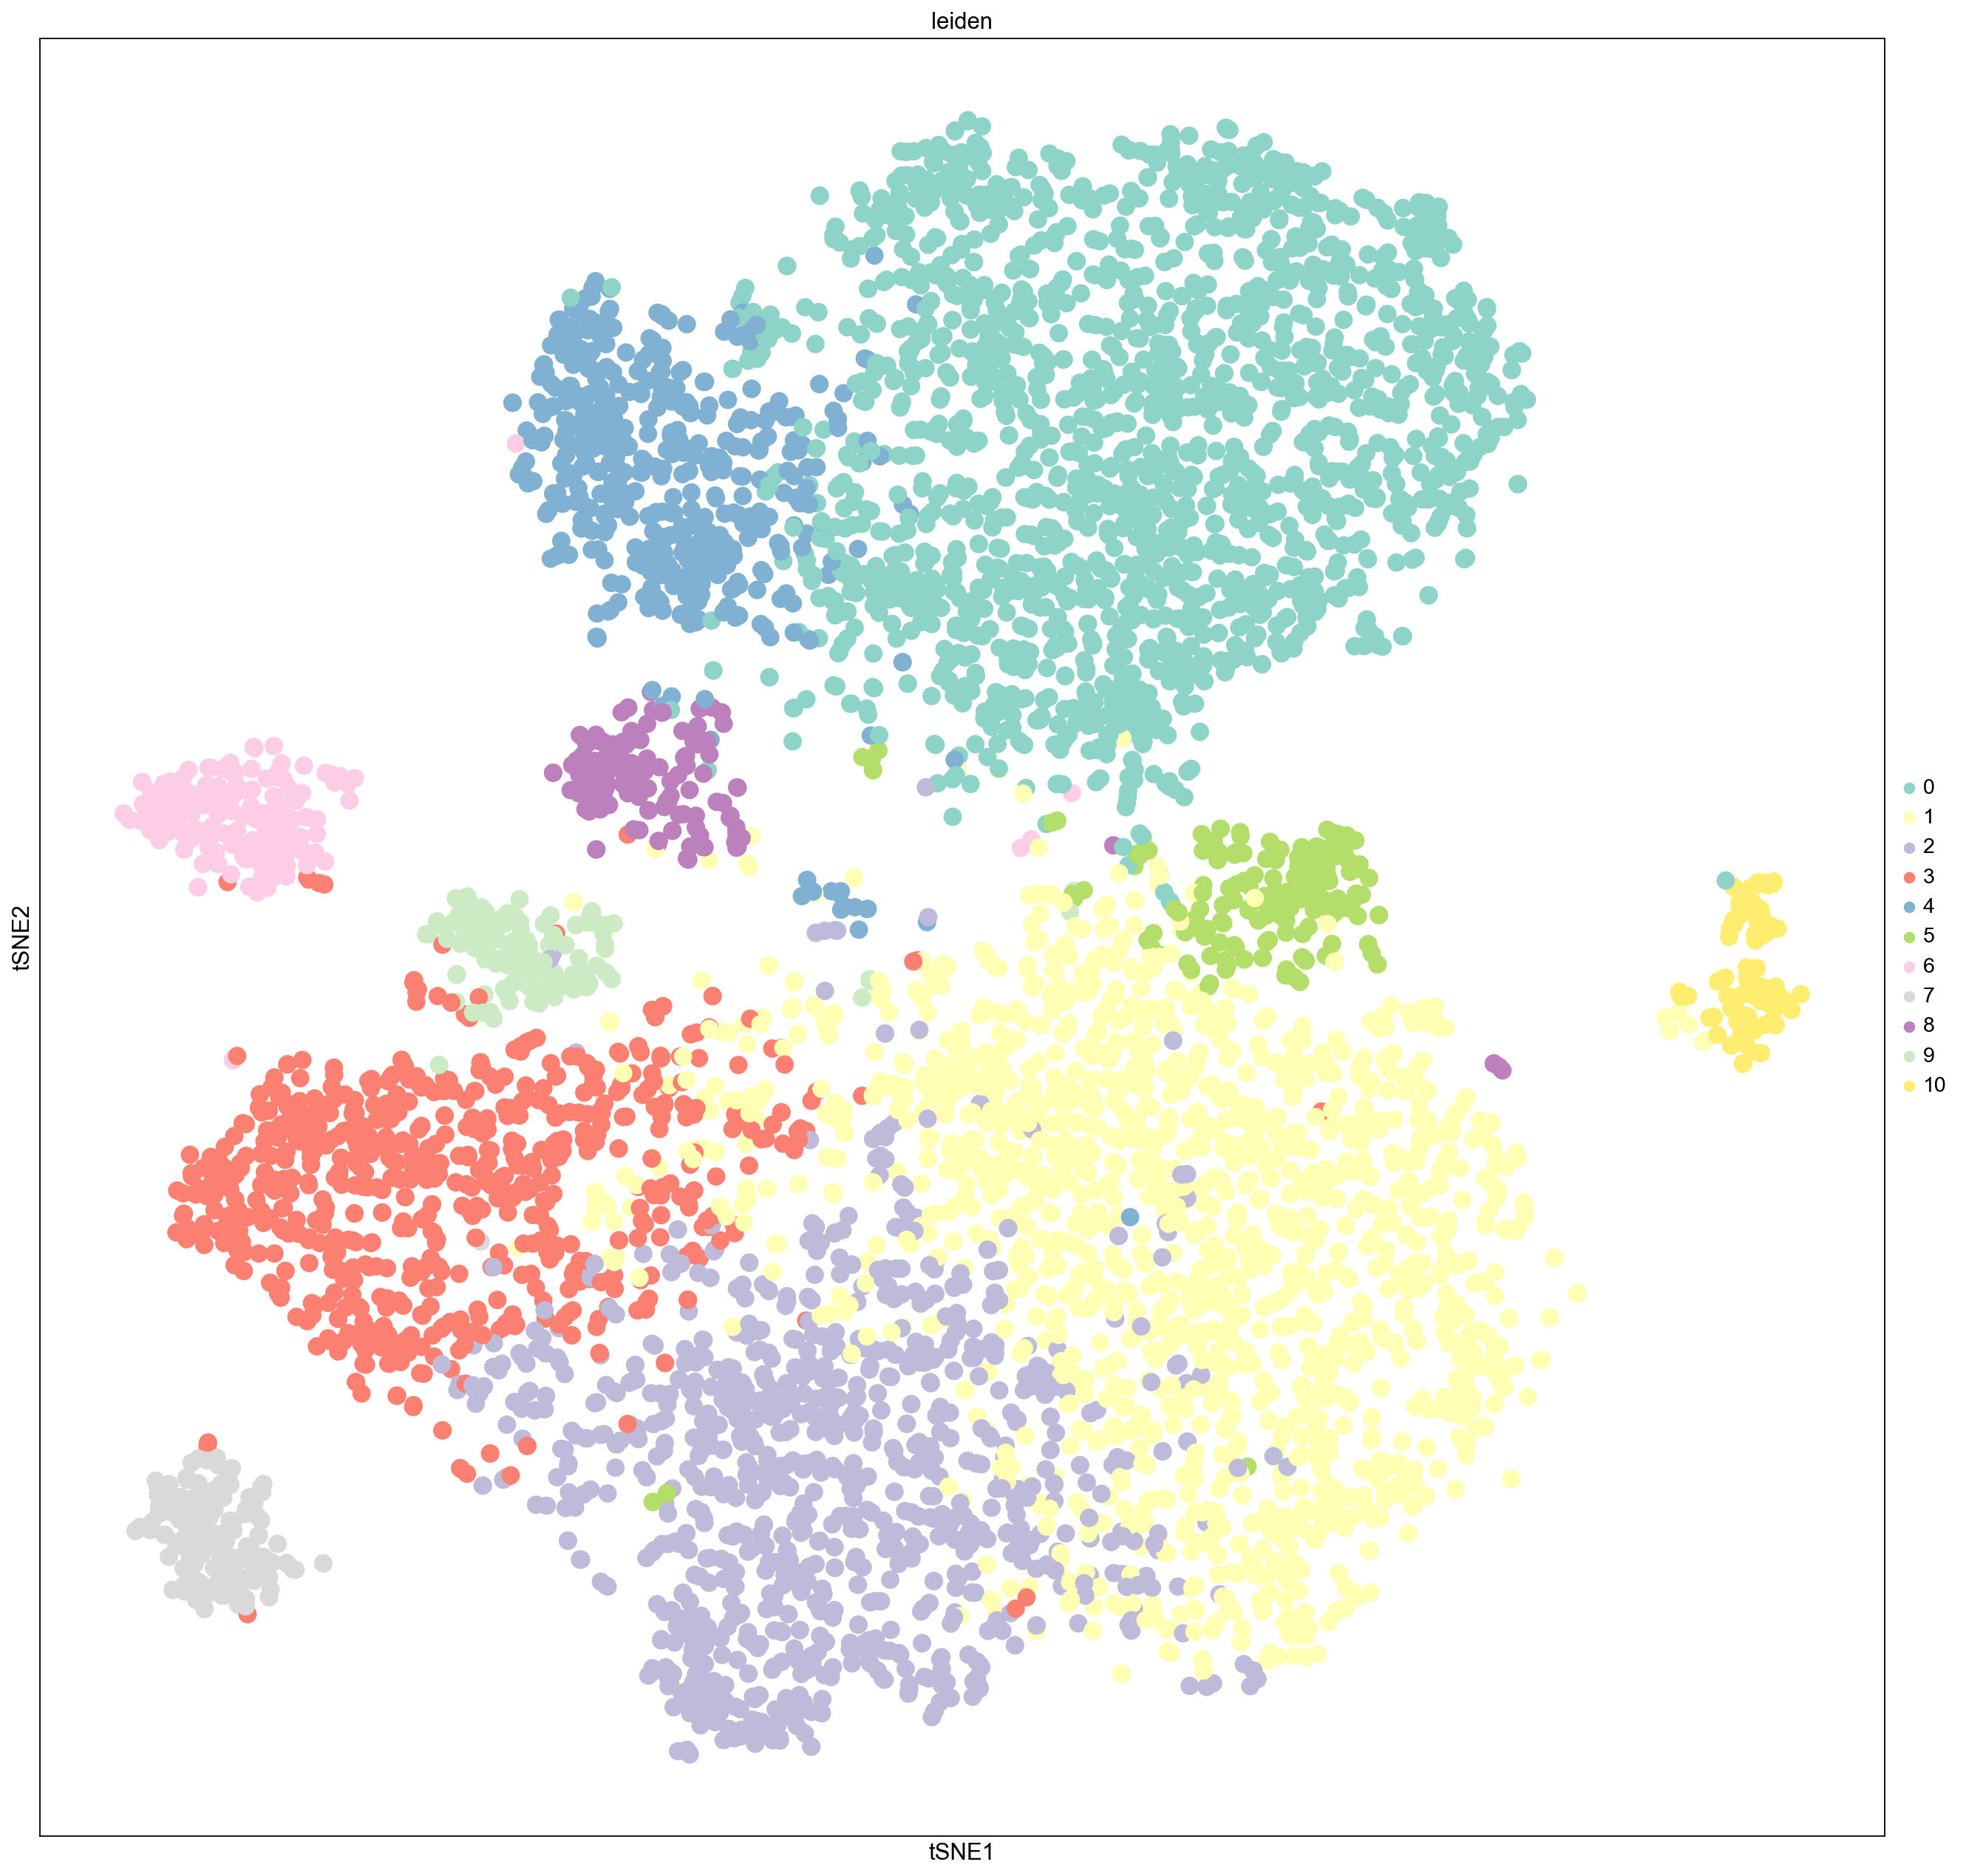

In [39]:
plt.rcParams['figure.figsize'] = [20, 20]

sc.pl.tsne(adata_m,
          color=['leiden'
          ],
           ncols=2,
           palette='Set3',
           
           size=500
          )

In [40]:
sc.tl.rank_genes_groups(adata_m,groupby='leiden')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


In [41]:
sc.pl.rank_genes_groups(adata_m,
                       fontsize=20,
                       ncols=2)

In [42]:
cell_type_df=pd.DataFrame(adata_m.obs['leiden'])

def label (row):
   if row['leiden'] == '0':
      return 'Hepatocyte'
   if row['leiden'] =='1':
      return 'mc38'
   if row['leiden'] == '2':
      return 'mc38'
   if row['leiden'] == '3':
      return 'Macrophage'
   if row['leiden']  == '4':
      return 'Hepatocyte'
   if row['leiden'] == '5':
      return 'MSC'
   if row['leiden'] == '6':
      return 'Kupffer'
   if row['leiden'] == '7':
      return 'Macrophage'
   if row['leiden'] == '8':
      return 'LSEC'
   if row['leiden'] == '9':
      return 'Lymphocyte'
   if row['leiden'] == '10':    
      return 'mc38'

    
cell_type_df_ =  pd.DataFrame(cell_type_df.apply (lambda row: label(row), axis=1),)

cell_type_df_.columns=['CellType']

adata_m.obs['CellType']=cell_type_df_

In [43]:
adata_m.uns['CellType_colors']=[
# '#d9d9d9',    #Hek293t   Grey
 '#fb8072', #Hepatocyte   Red
 '#fdb462', #Kupffer   Orange
 '#80b1d3', #LSEC   Blue
 '#bc80bd', #Lymphocyte   Purple 
 '#8dd3c7',#MSC    Cyan 
 '#ccebc5', #Macrophage   Light Green
 '#ffed6f',#mc38    Yellow
]

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'CellType' as categorical


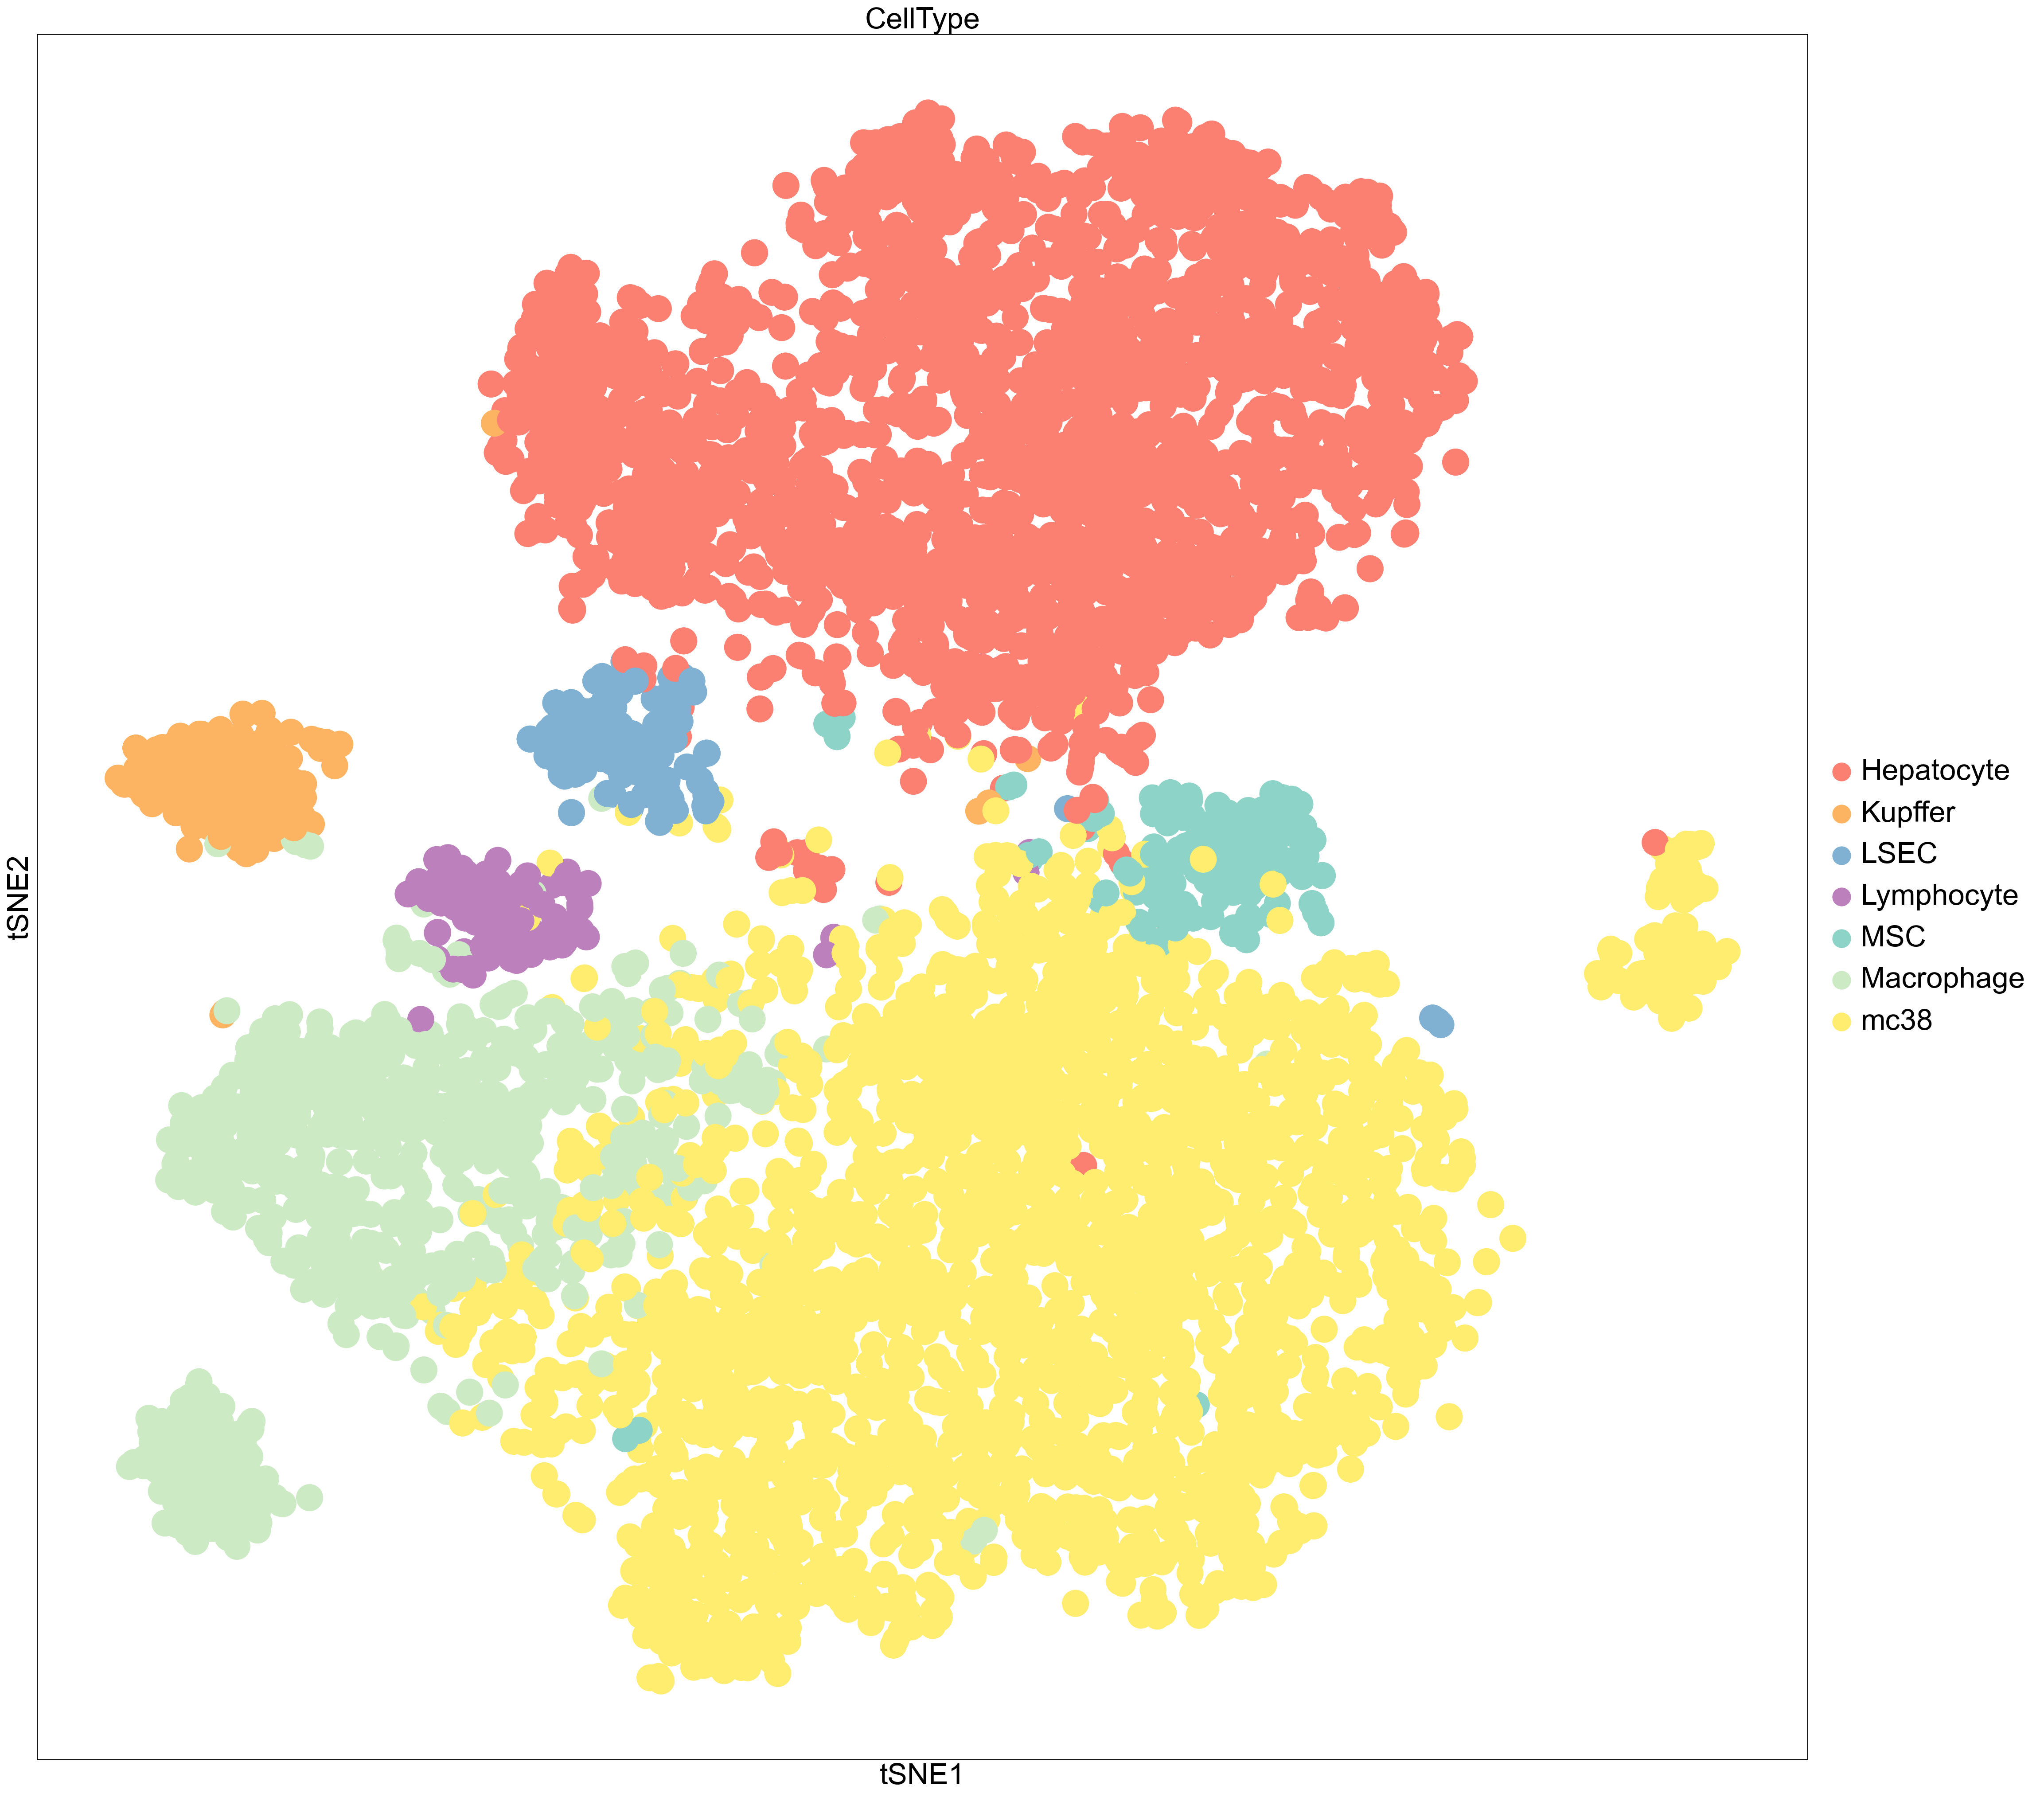

In [44]:
plt.rcParams['figure.figsize'] = [32, 32]
plt.rcParams['legend.fontsize'] = 30
plt.rcParams['legend.markerscale'] = 3
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.titlesize'] = 30
sc.pl.tsne(adata_m,
          color=['CellType'],
    
           ncols=1,
           size=3000
          )

In [45]:
##concoordinace between batches of liver data

#expression correlations between batches

In [46]:
adata_0 = adata_m[adata_m.obs.batch == '0']
adata_1 = adata_m[adata_m.obs.batch == '1']
adata_2 = adata_m[adata_m.obs.batch == '2']
adata_3 = adata_m[adata_m.obs.batch == '3']
adata_4 = adata_m[adata_m.obs.batch == '4']


/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


<AxesSubplot:>

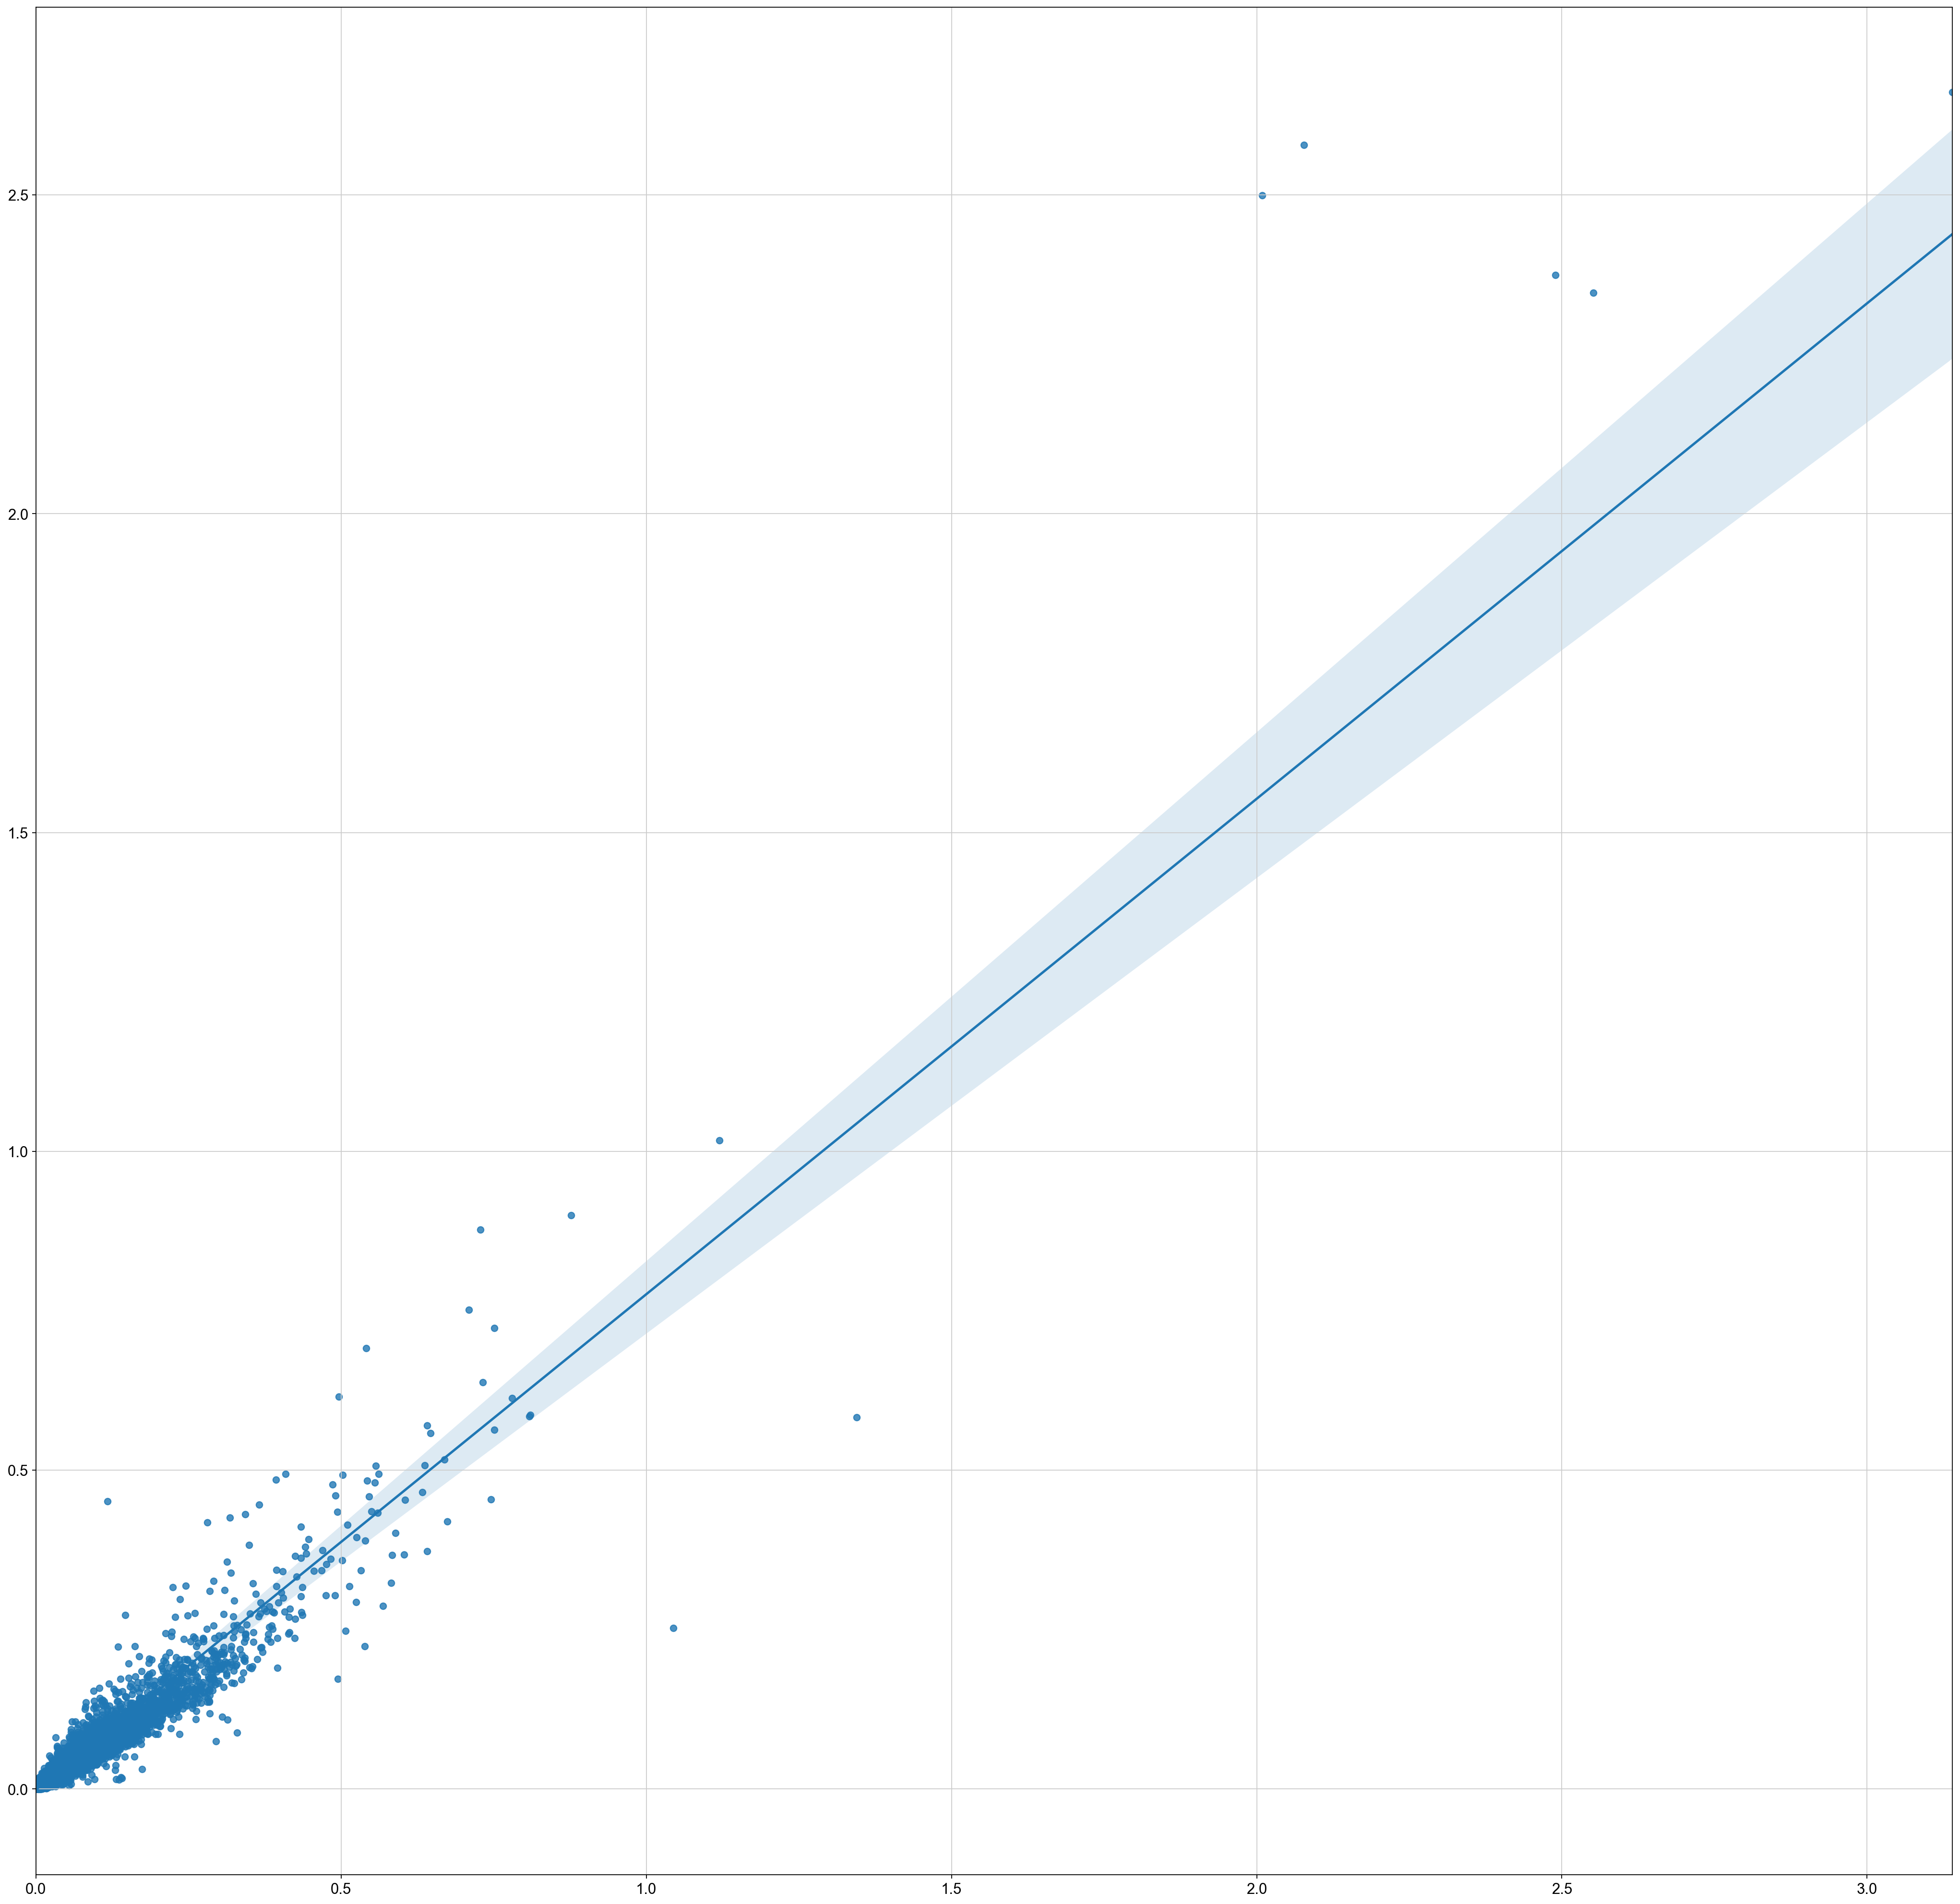

In [47]:


plt.rcParams['figure.figsize'] = [32, 32]
plt.rcParams['legend.fontsize'] = 30
plt.rcParams['legend.markerscale'] = 3
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.titlesize'] = 30




sns.regplot(
               x=adata_1.raw.to_adata().to_df().mean(),
               y=adata_2.raw.to_adata().to_df().mean()
                )

In [48]:
#pearson correlation between mean expression of two batches
adata_1.raw.to_adata().to_df().mean().corr(adata_2.raw.to_adata().to_df().mean())

0.95826536428216

In [49]:
##get plate map file 
plate_map='~/projects/XYZeq/data/20181219_species_exp/plate23_map.csv'


spatial_map=pd.read_csv(plate_map, header=None, names=['barcode', 'X', 'Y'])

spatial_map['Y'] = -spatial_map['Y']

tmp=[]

for index, row in spatial_map.iterrows():
    if row['X']%2==0:
        m=row['Y'] - .5
        tmp.append(m)
    else:
        tmp.append(row['Y'])
        
spatial_map['Y_offset'] = pd.DataFrame(tmp)

spatial_map = spatial_map.drop(['Y'],axis=1)

spatial_map.columns = ['barcode','X','Y']


In [50]:
adata_m.obs = adata_m.obs.reset_index().merge(spatial_map, on='barcode',how='left').set_index('index')

In [81]:
adata_batch2 = adata_m[adata_m.obs.batch == '2']

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
 

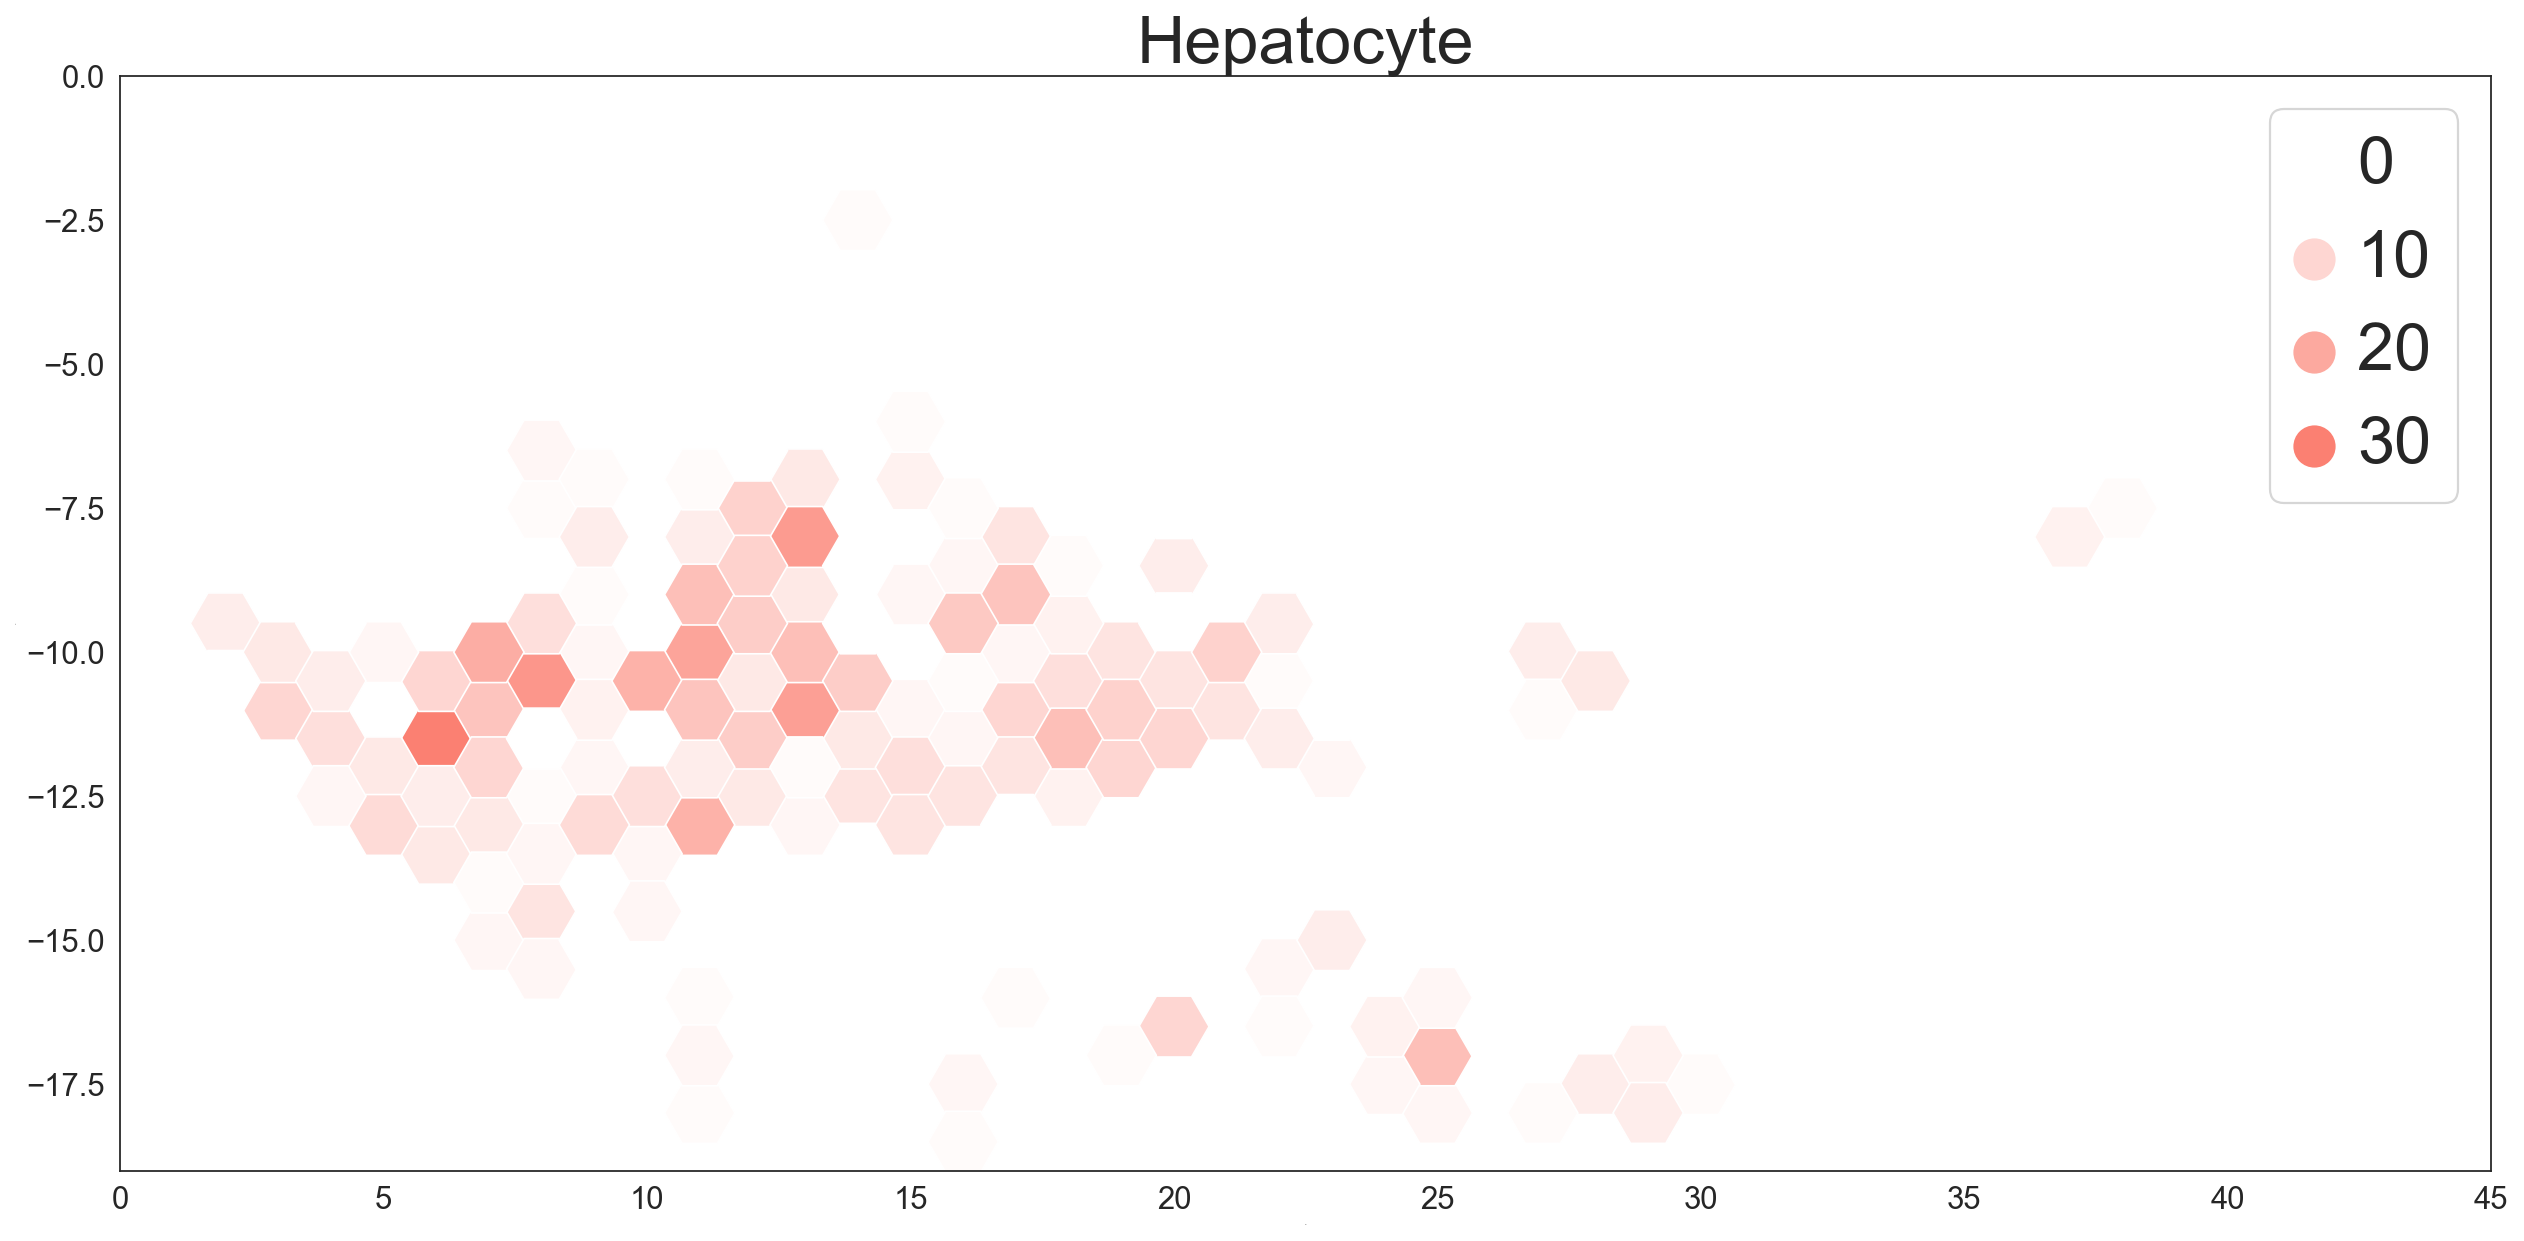

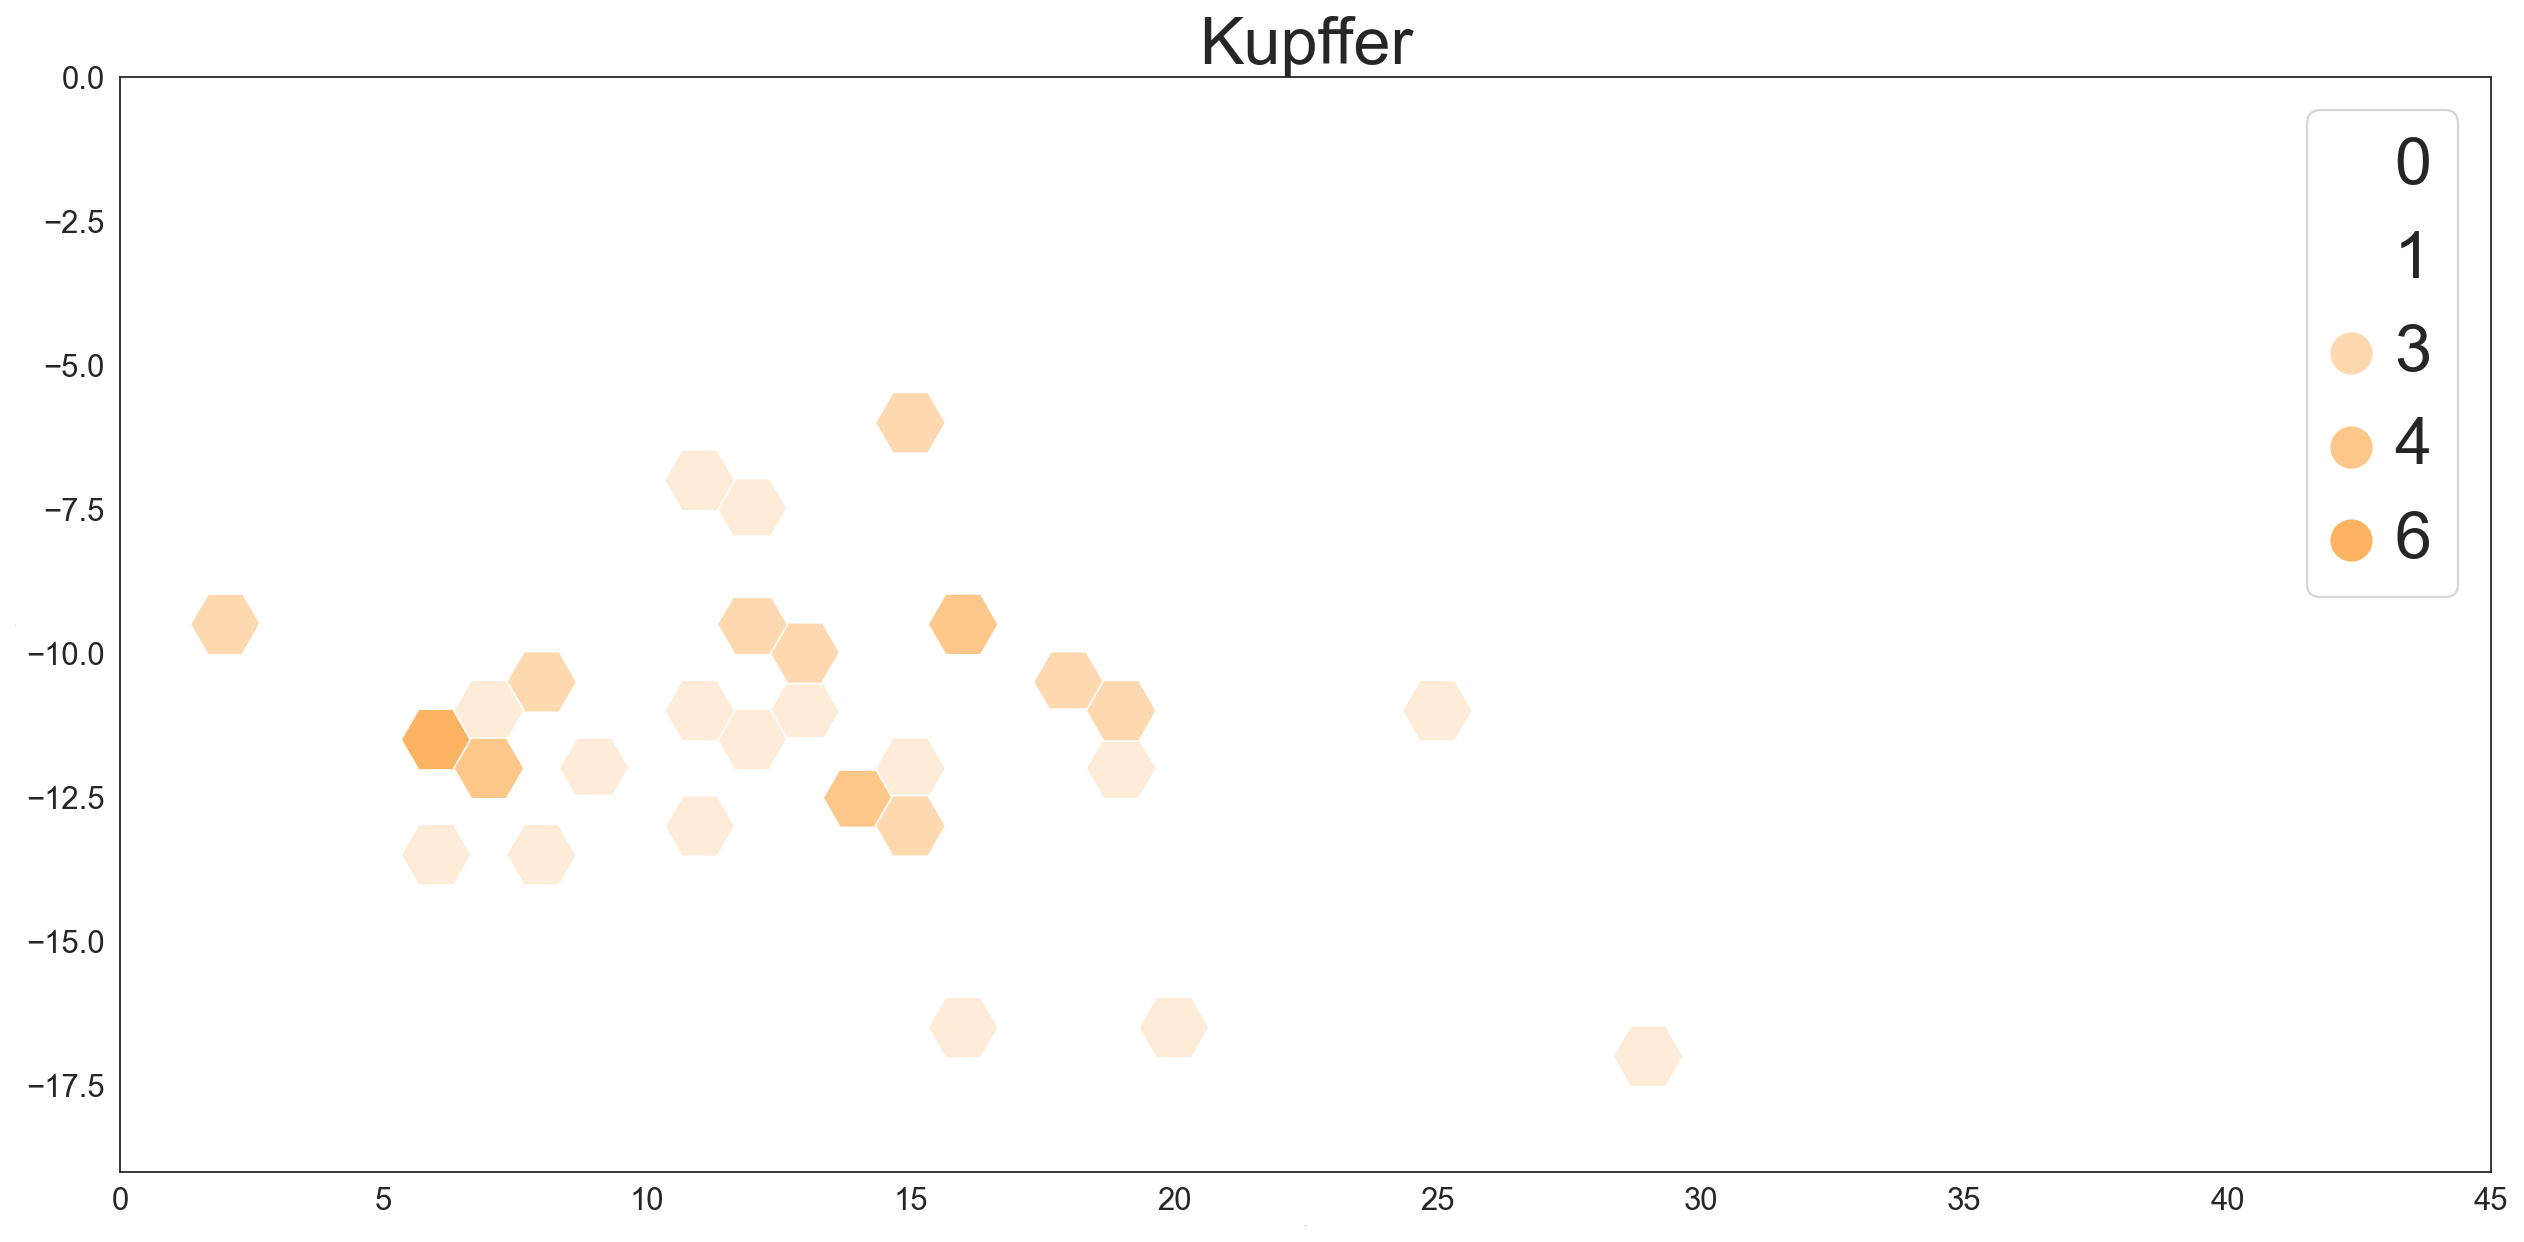

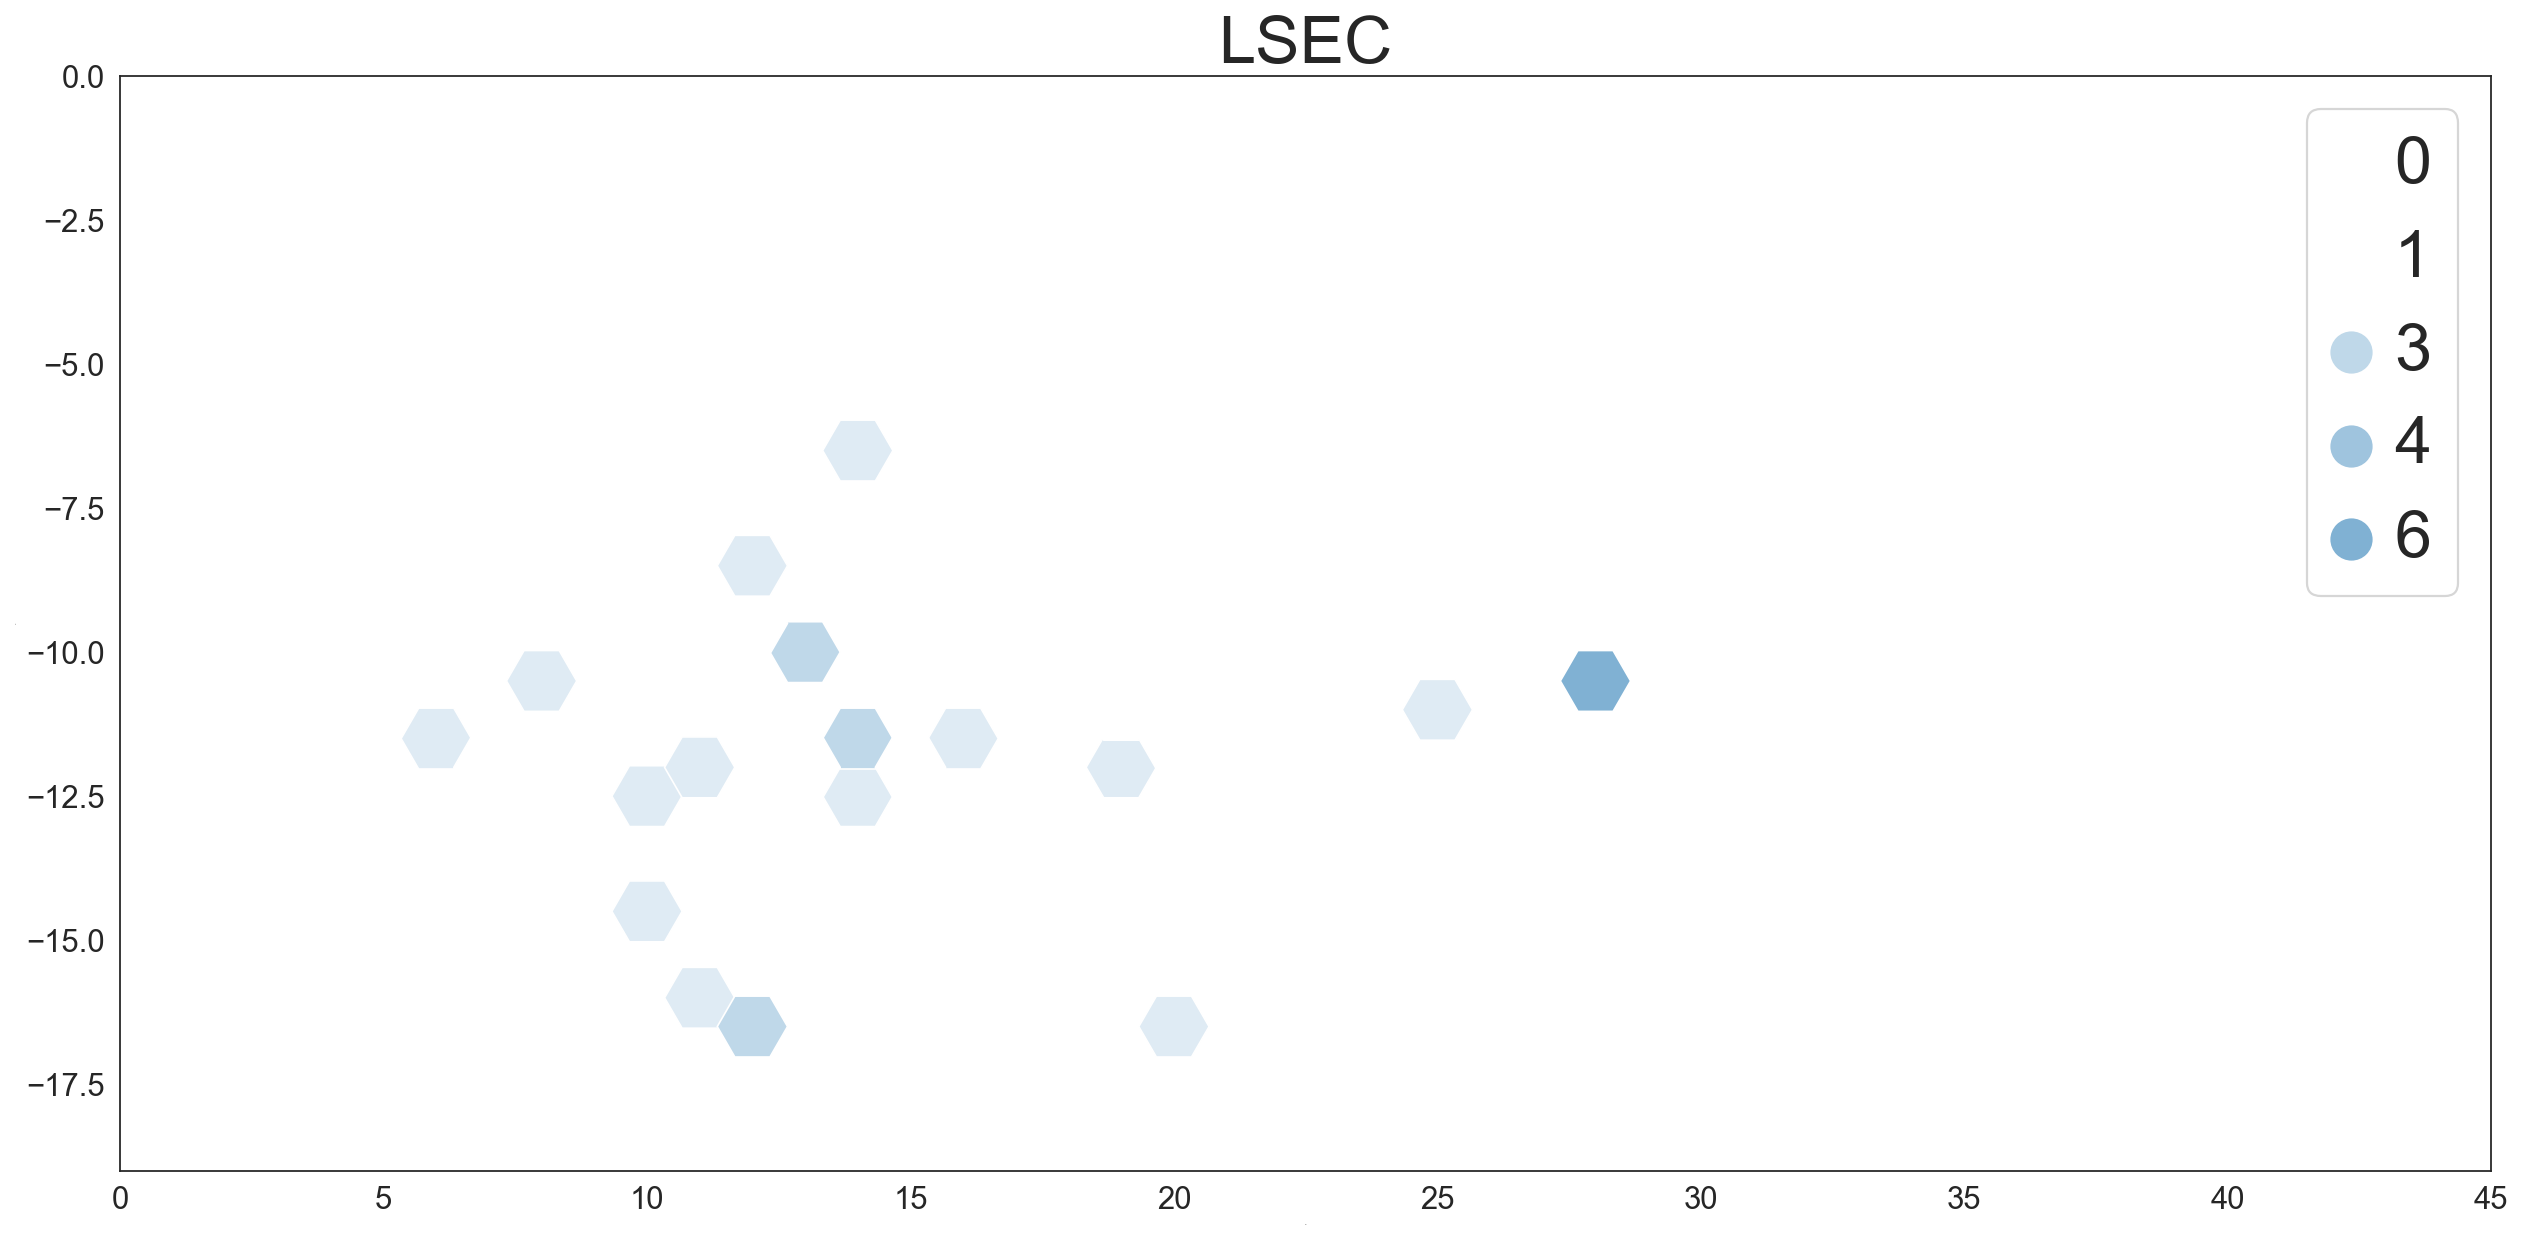

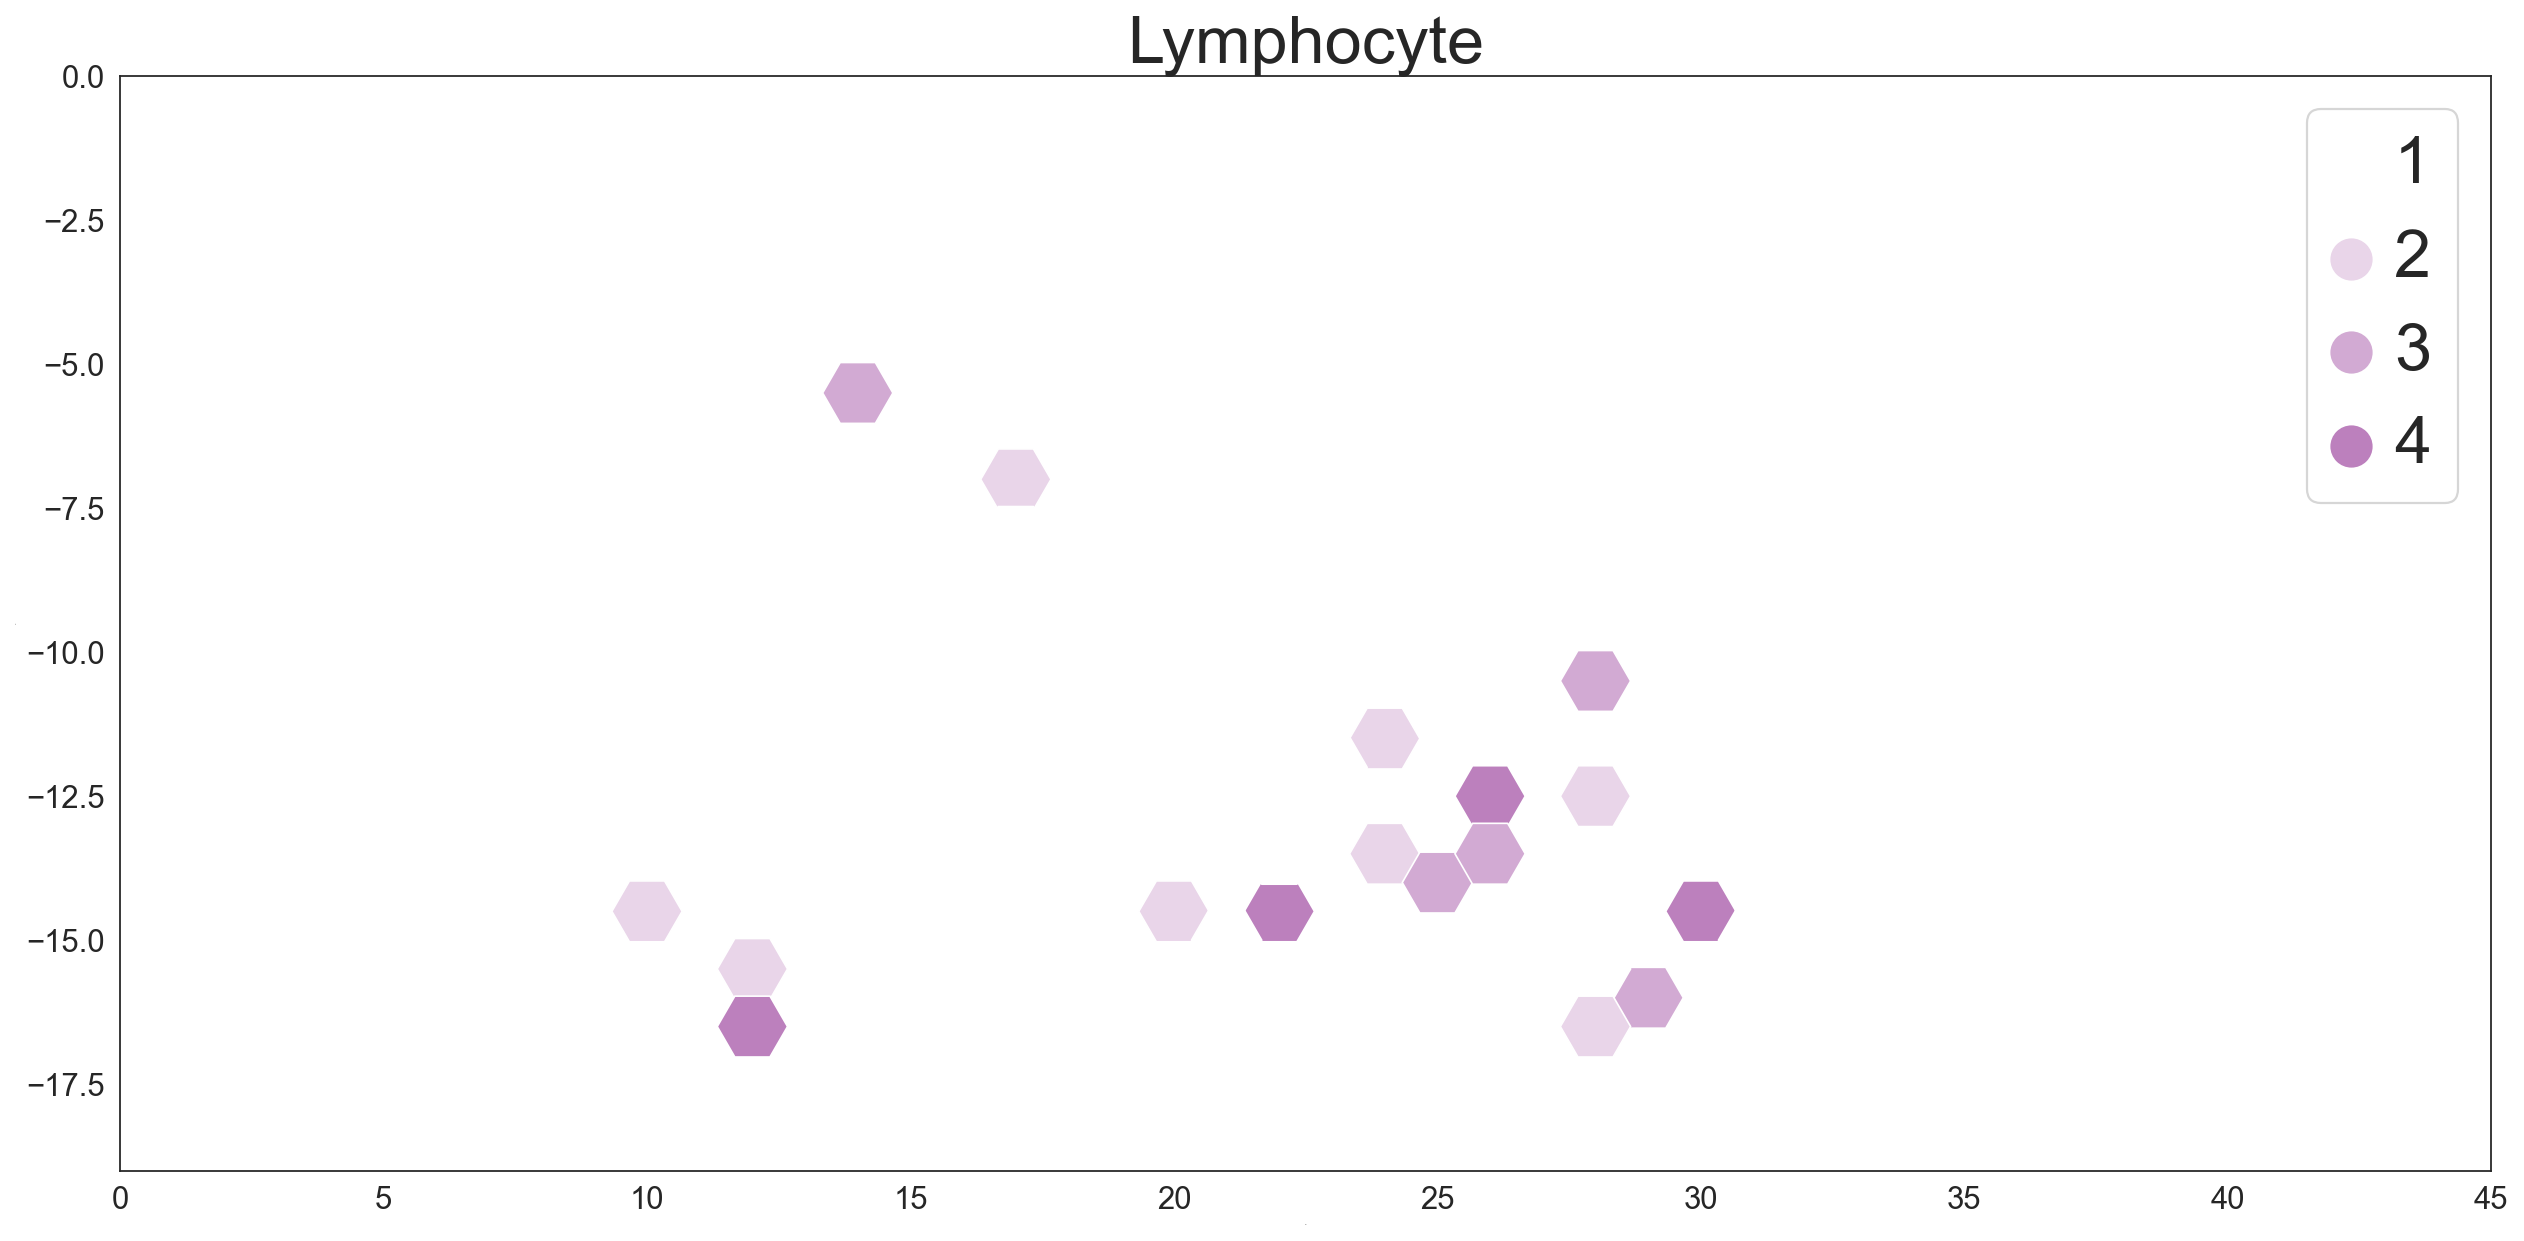

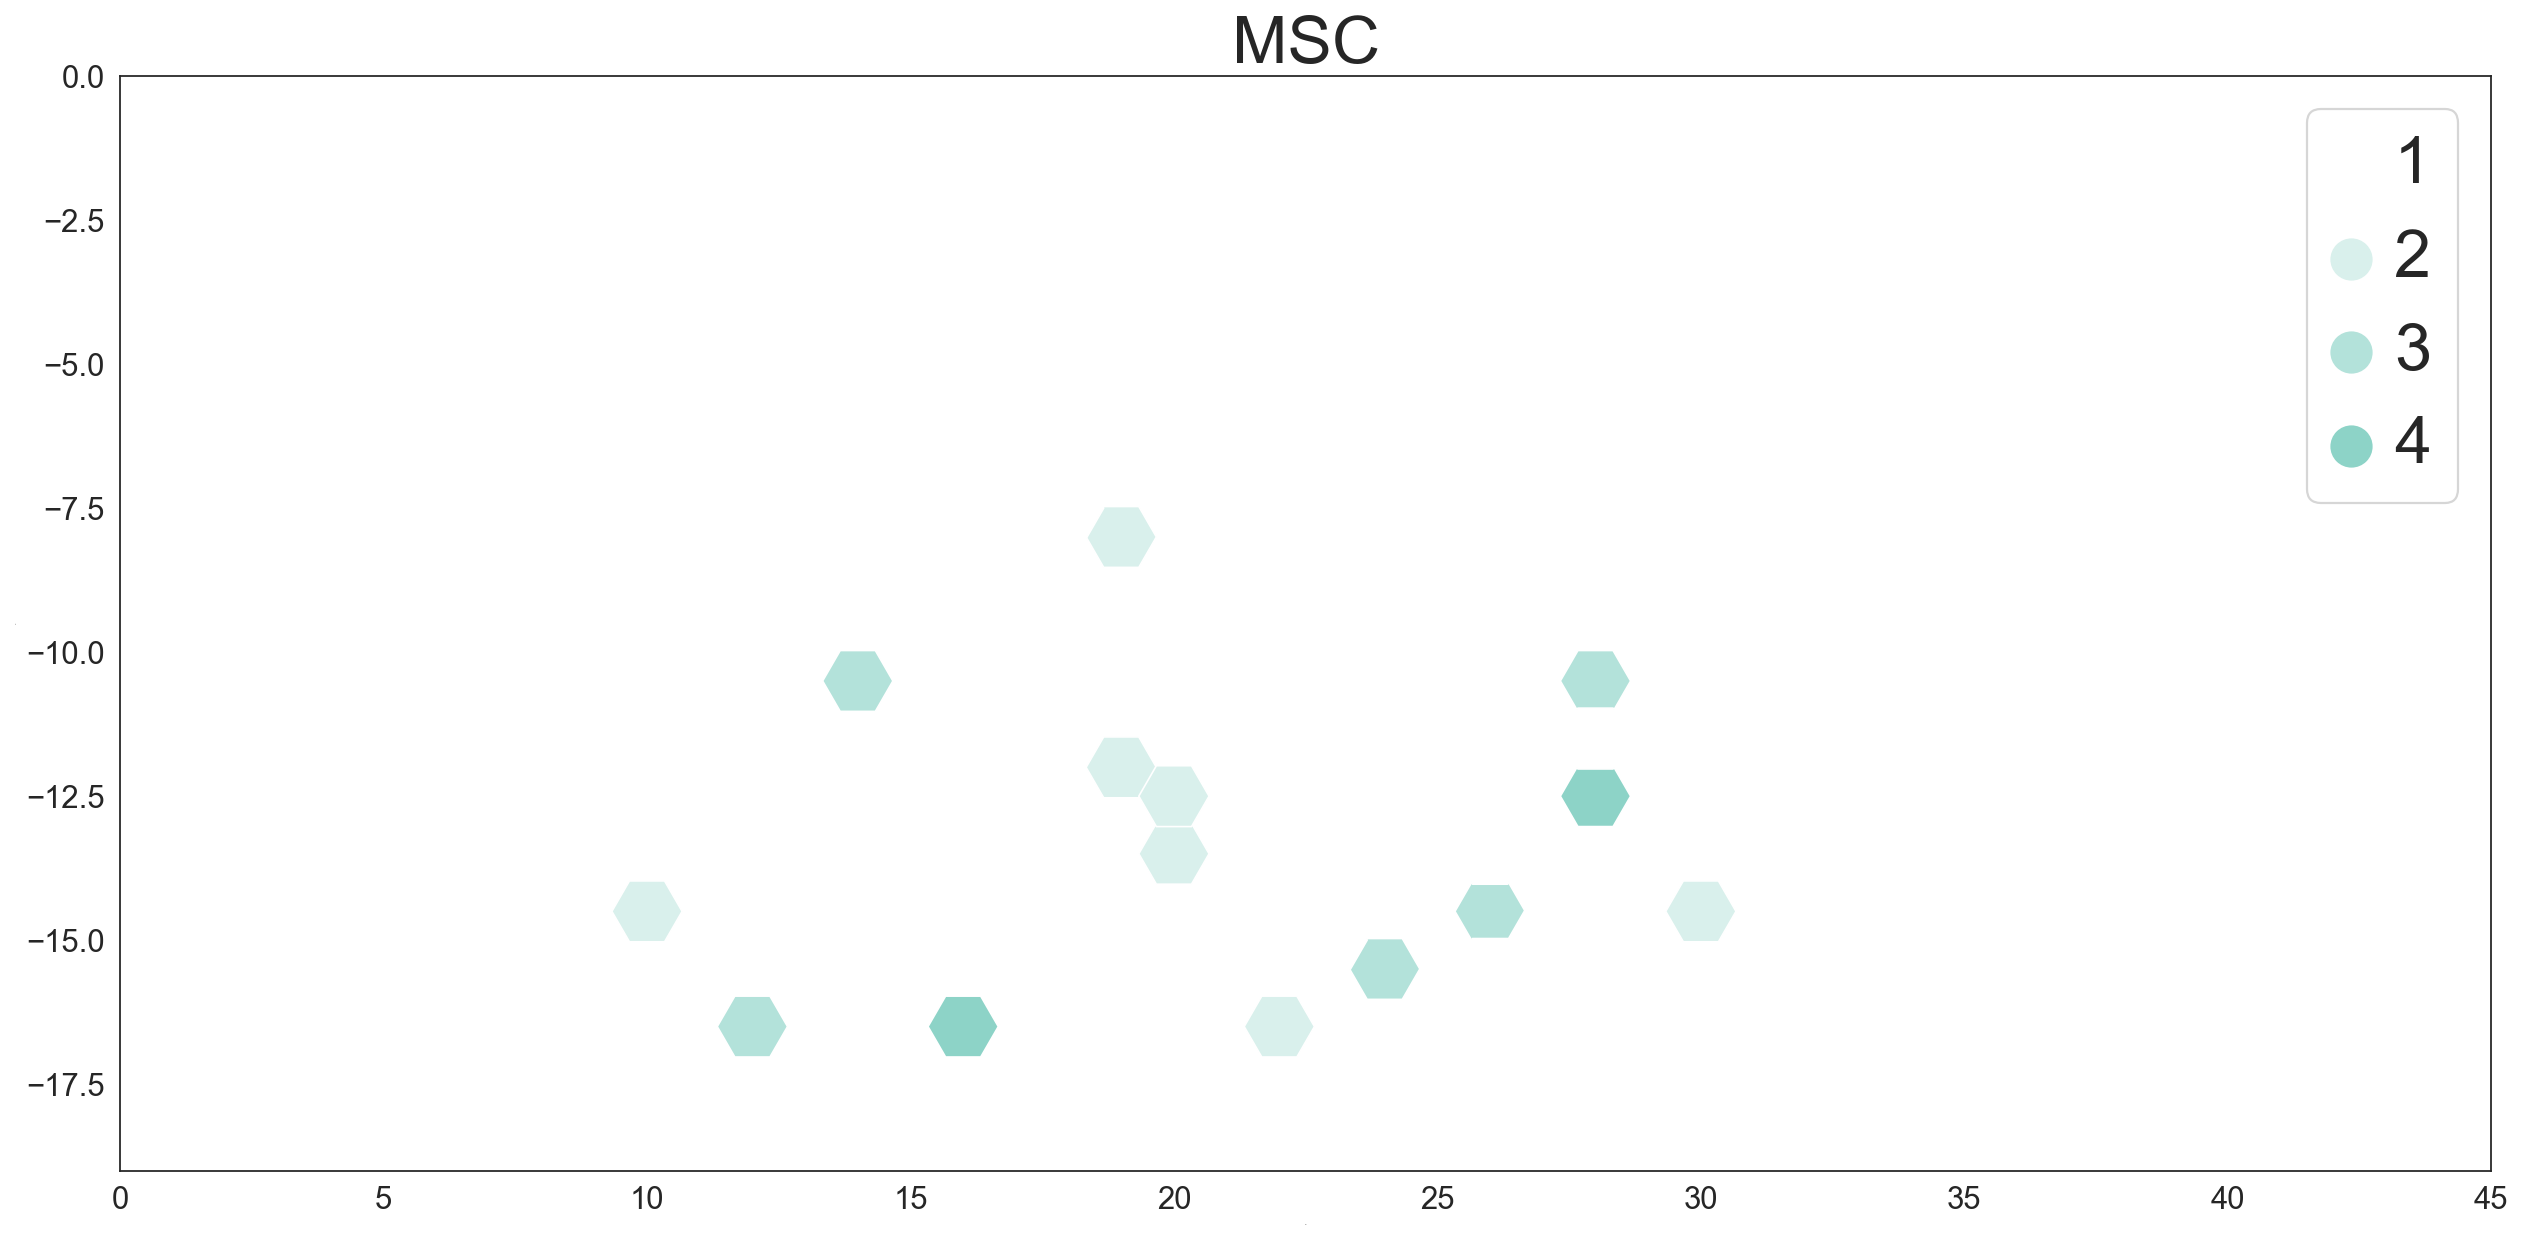

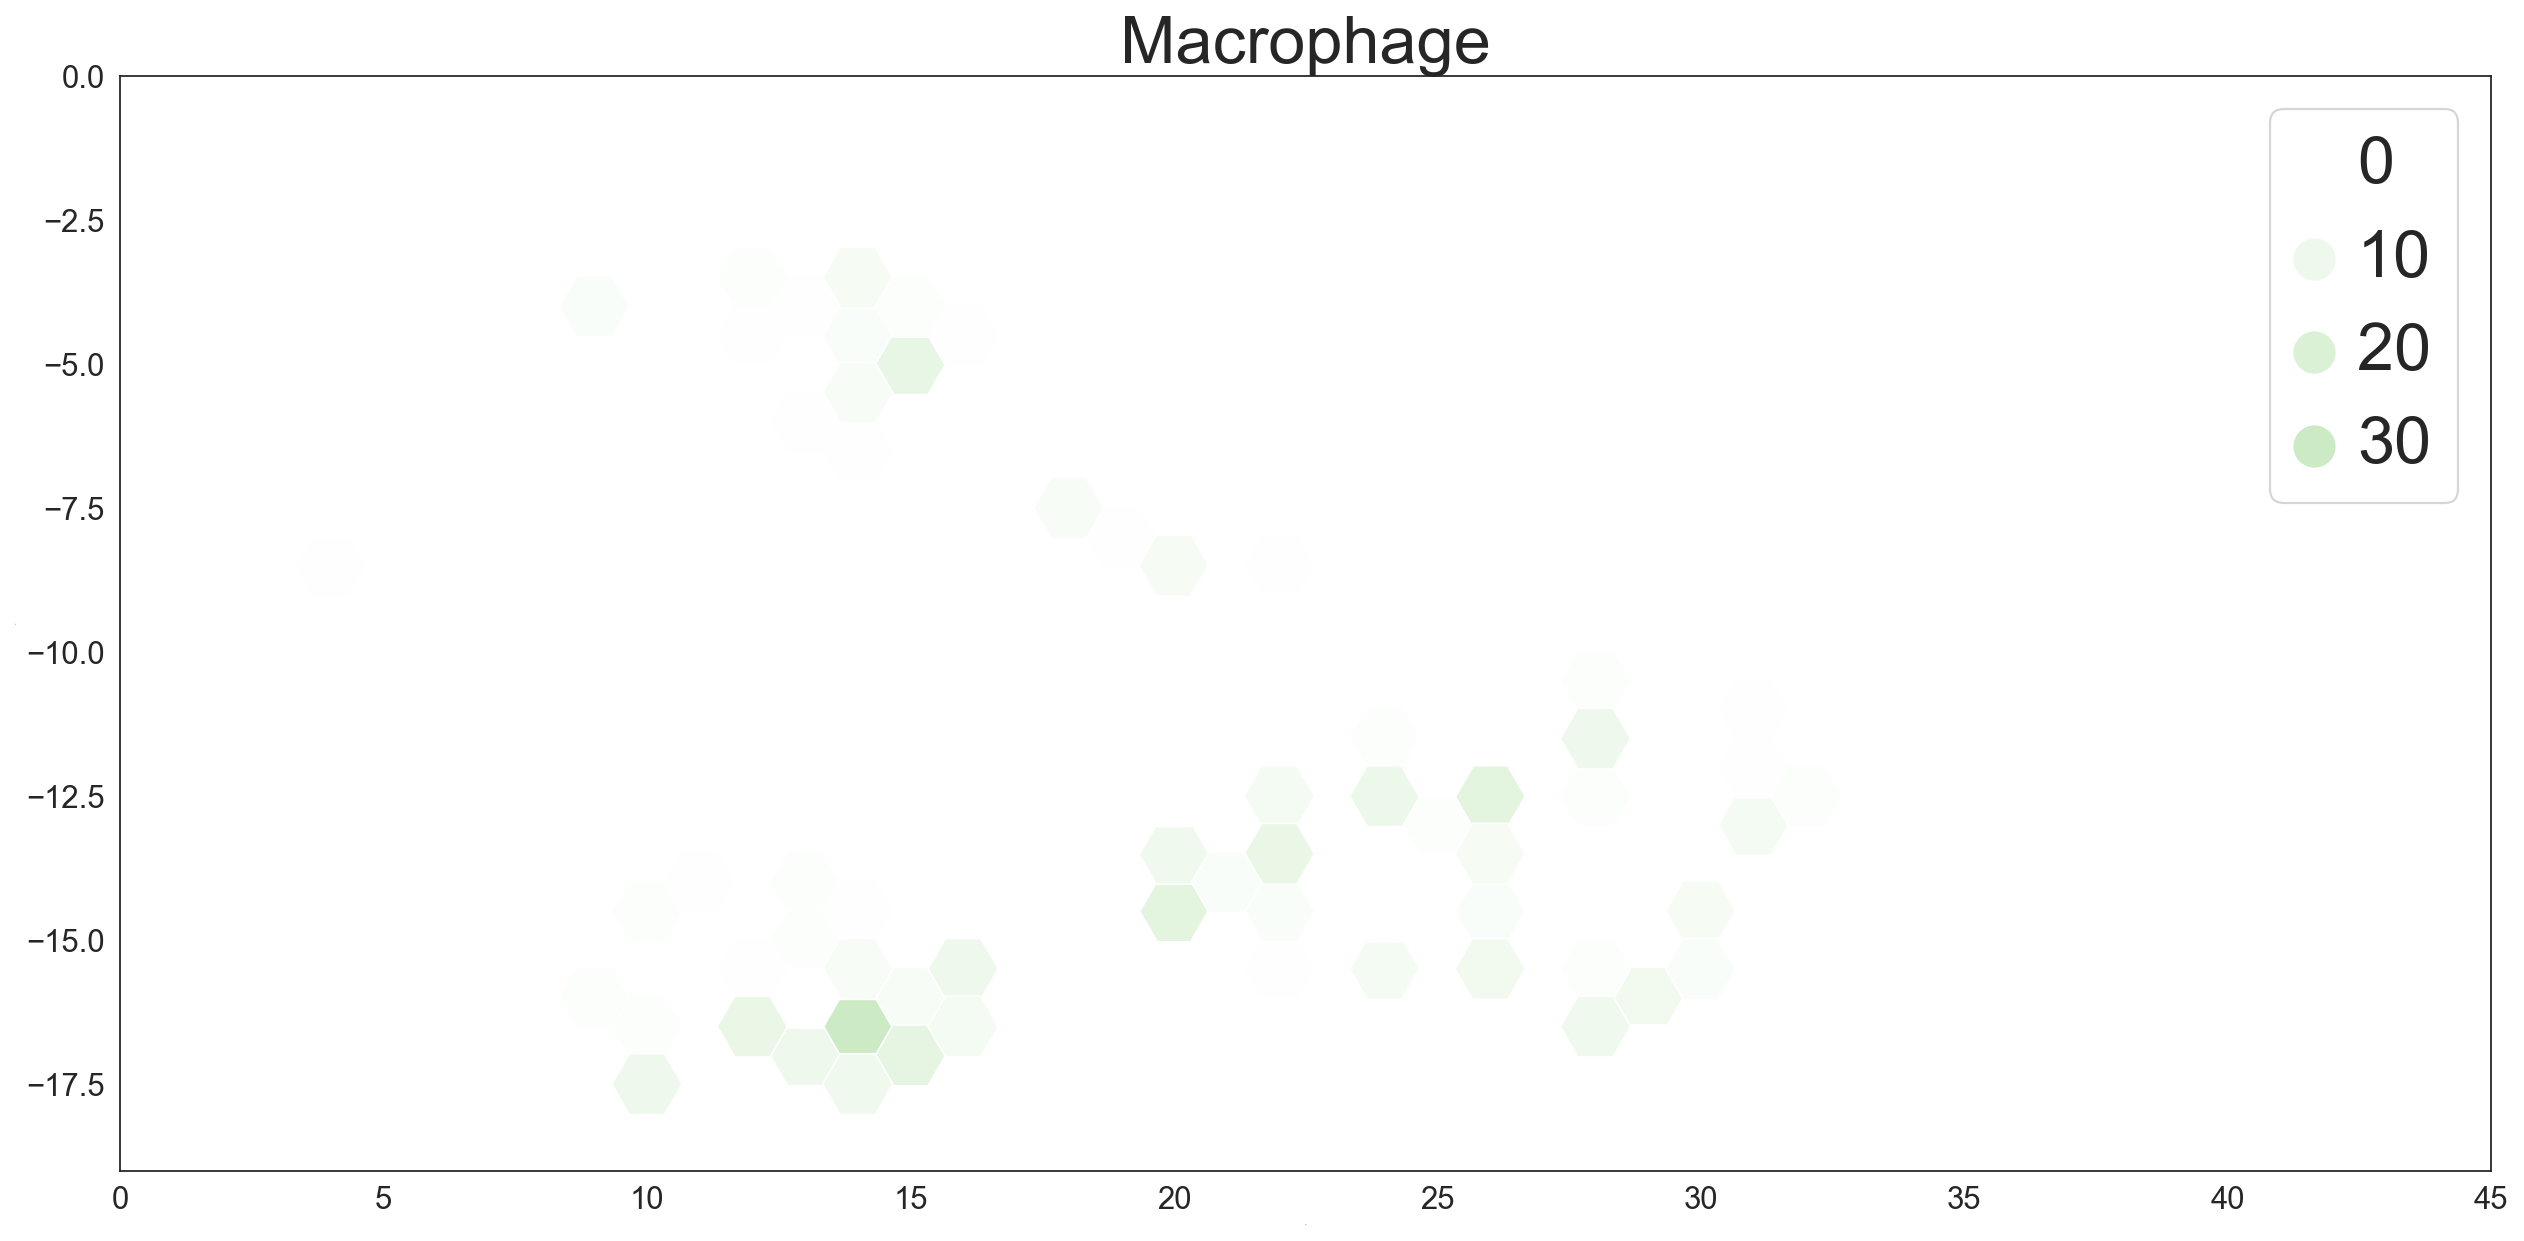

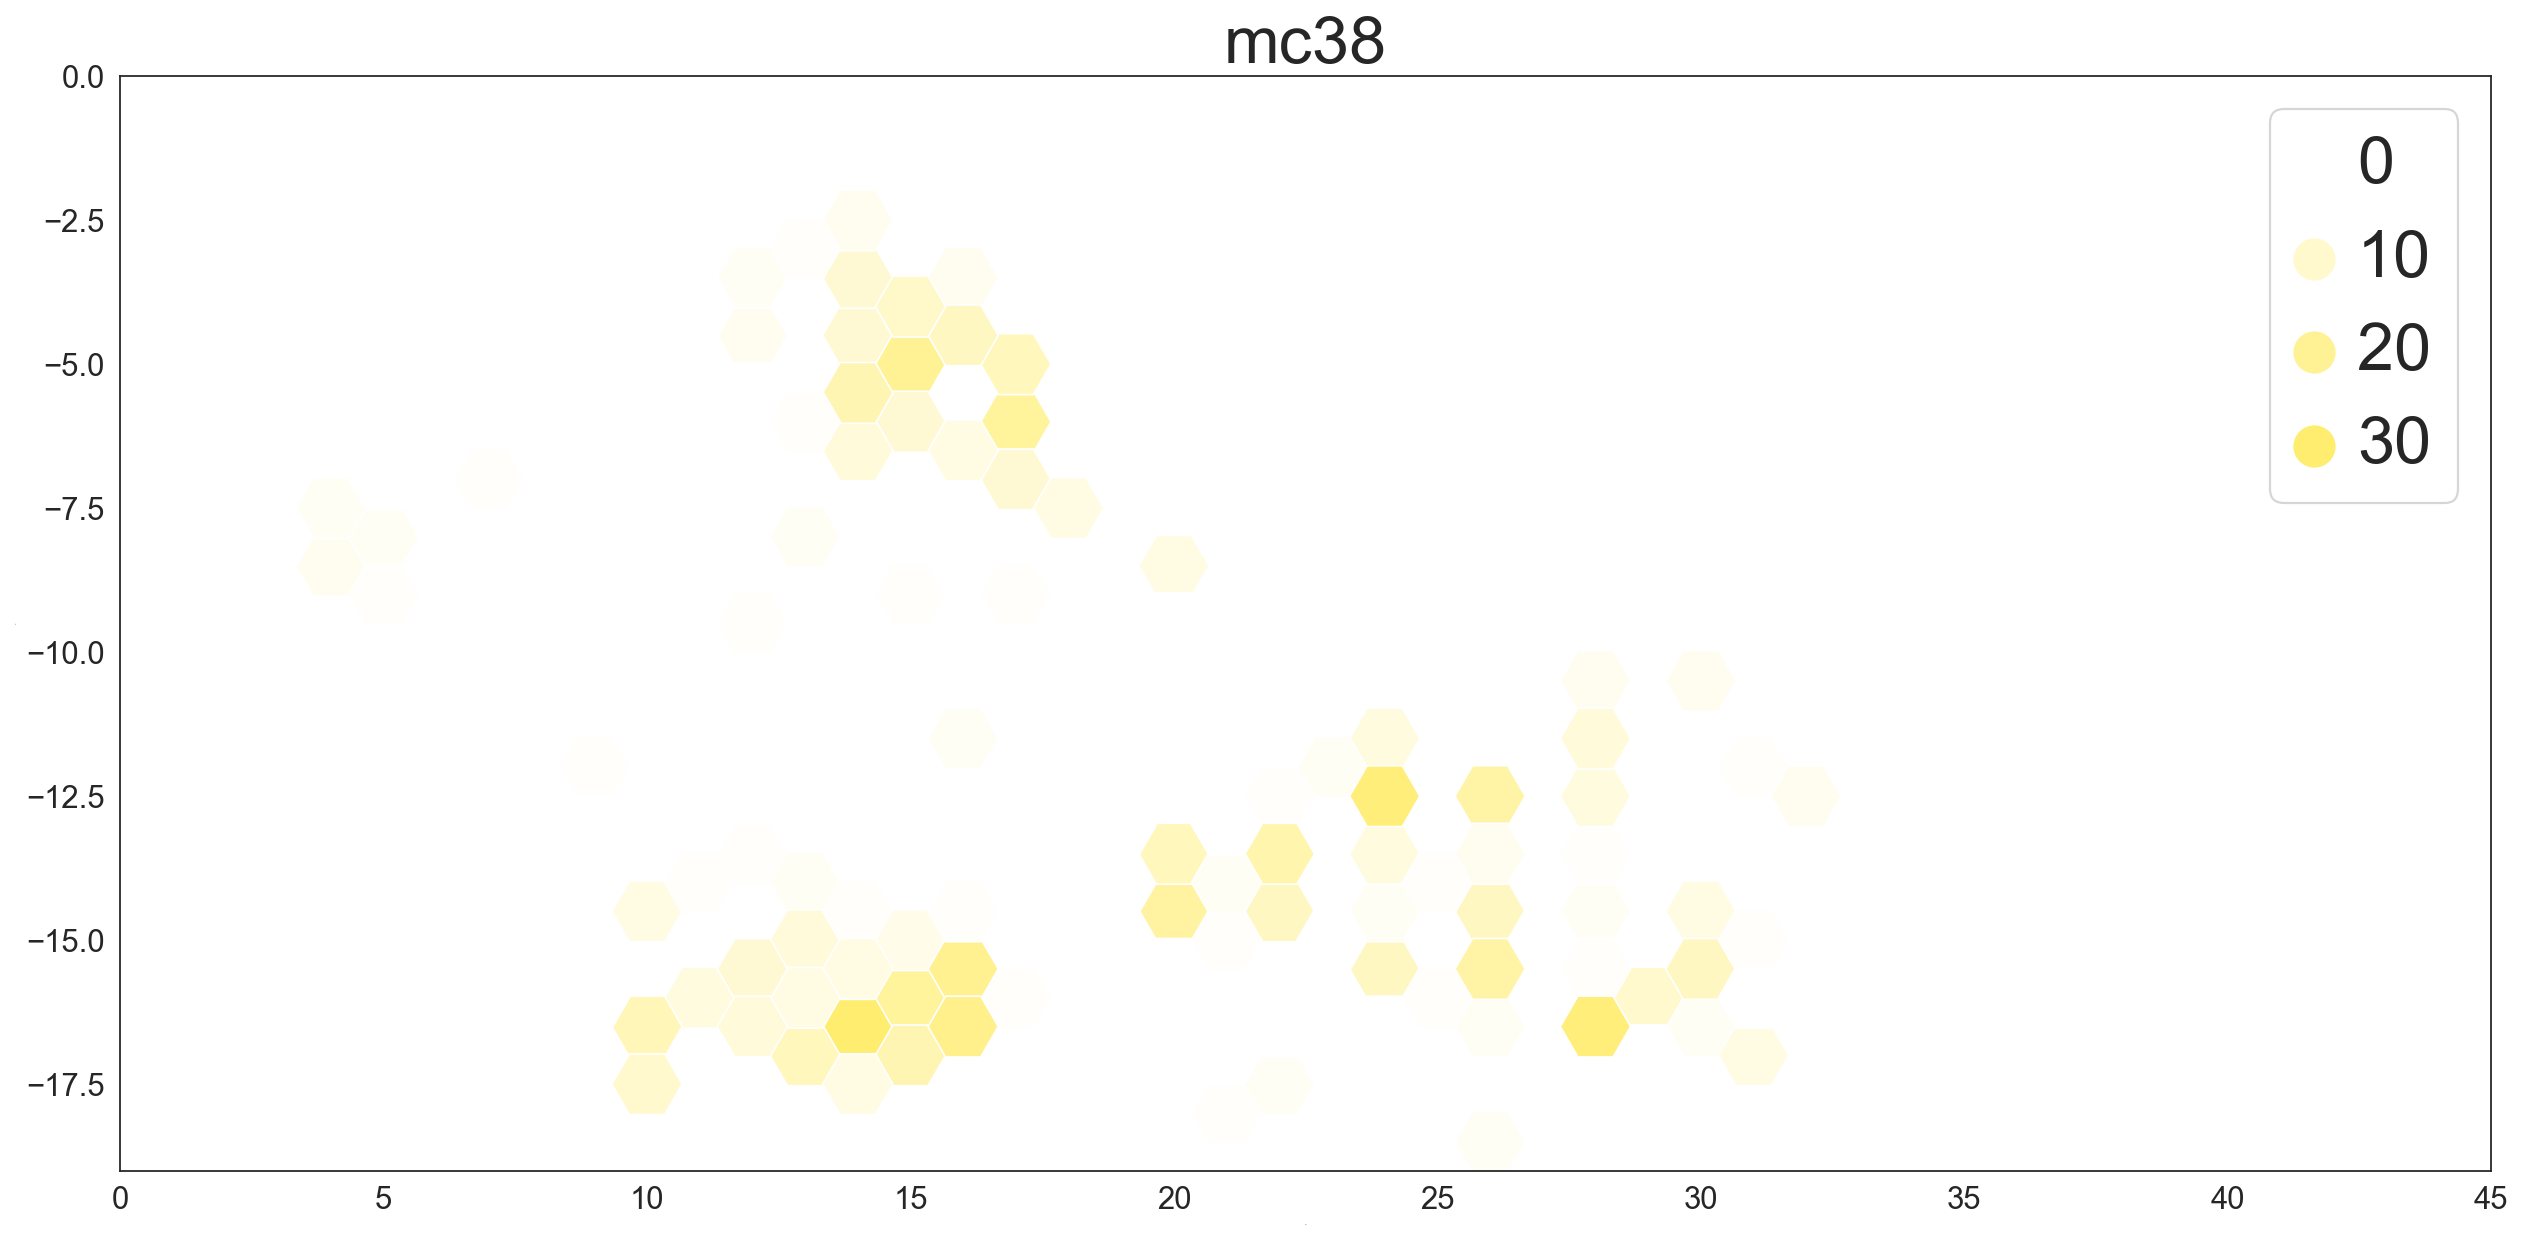

<Figure size 1520x720 with 0 Axes>

In [93]:
#plt.rcParams['figure.figsize'] = [19, 9]

plt.rcParams['legend.fontsize'] = 30
plt.rcParams['legend.markerscale'] = 3
plt.rcParams['axes.labelsize'] = 0
plt.rcParams['axes.titlesize'] = 30



sns.set_style("white", {'axes.grid' : False})

#sns.despine(trim=True)

#fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(9, 6))


for i in adata_m.obs.CellType.cat.categories:

    plt.xlim(0, 45)
    plt.ylim(-19,0)
    
    cell_type_color = adata_batch1[adata_batch1.obs.CellType == i].uns['CellType_colors'].item()
    cell_type_color_map = mpl.colors.LinearSegmentedColormap.from_list("", ["#ffffff",cell_type_color])

    g = sns.scatterplot(data=adata_batch1[adata_batch1.obs.CellType == i].obs.groupby(['barcode','X','Y']).size().reset_index(name="count"),
                x='X',
                y='Y',
                marker="H",
                s=1000,
                hue=adata_batch1[adata_batch1.obs.CellType == i].obs.groupby(['barcode','X','Y']).size().reset_index(name="count")['count'].tolist(),
                palette=cell_type_color_map,
                legend='brief'
                        ###for solid colors:
                #c=[cell_type_color]#[adata_batch1[adata_batch1.obs.CellType == i].uns['CellType_colors'].item()]

               )

    #g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
    g.set_title(i)
    plt.figure()
    

    


/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


AttributeError: 'Figure' object has no attribute 'scatter'

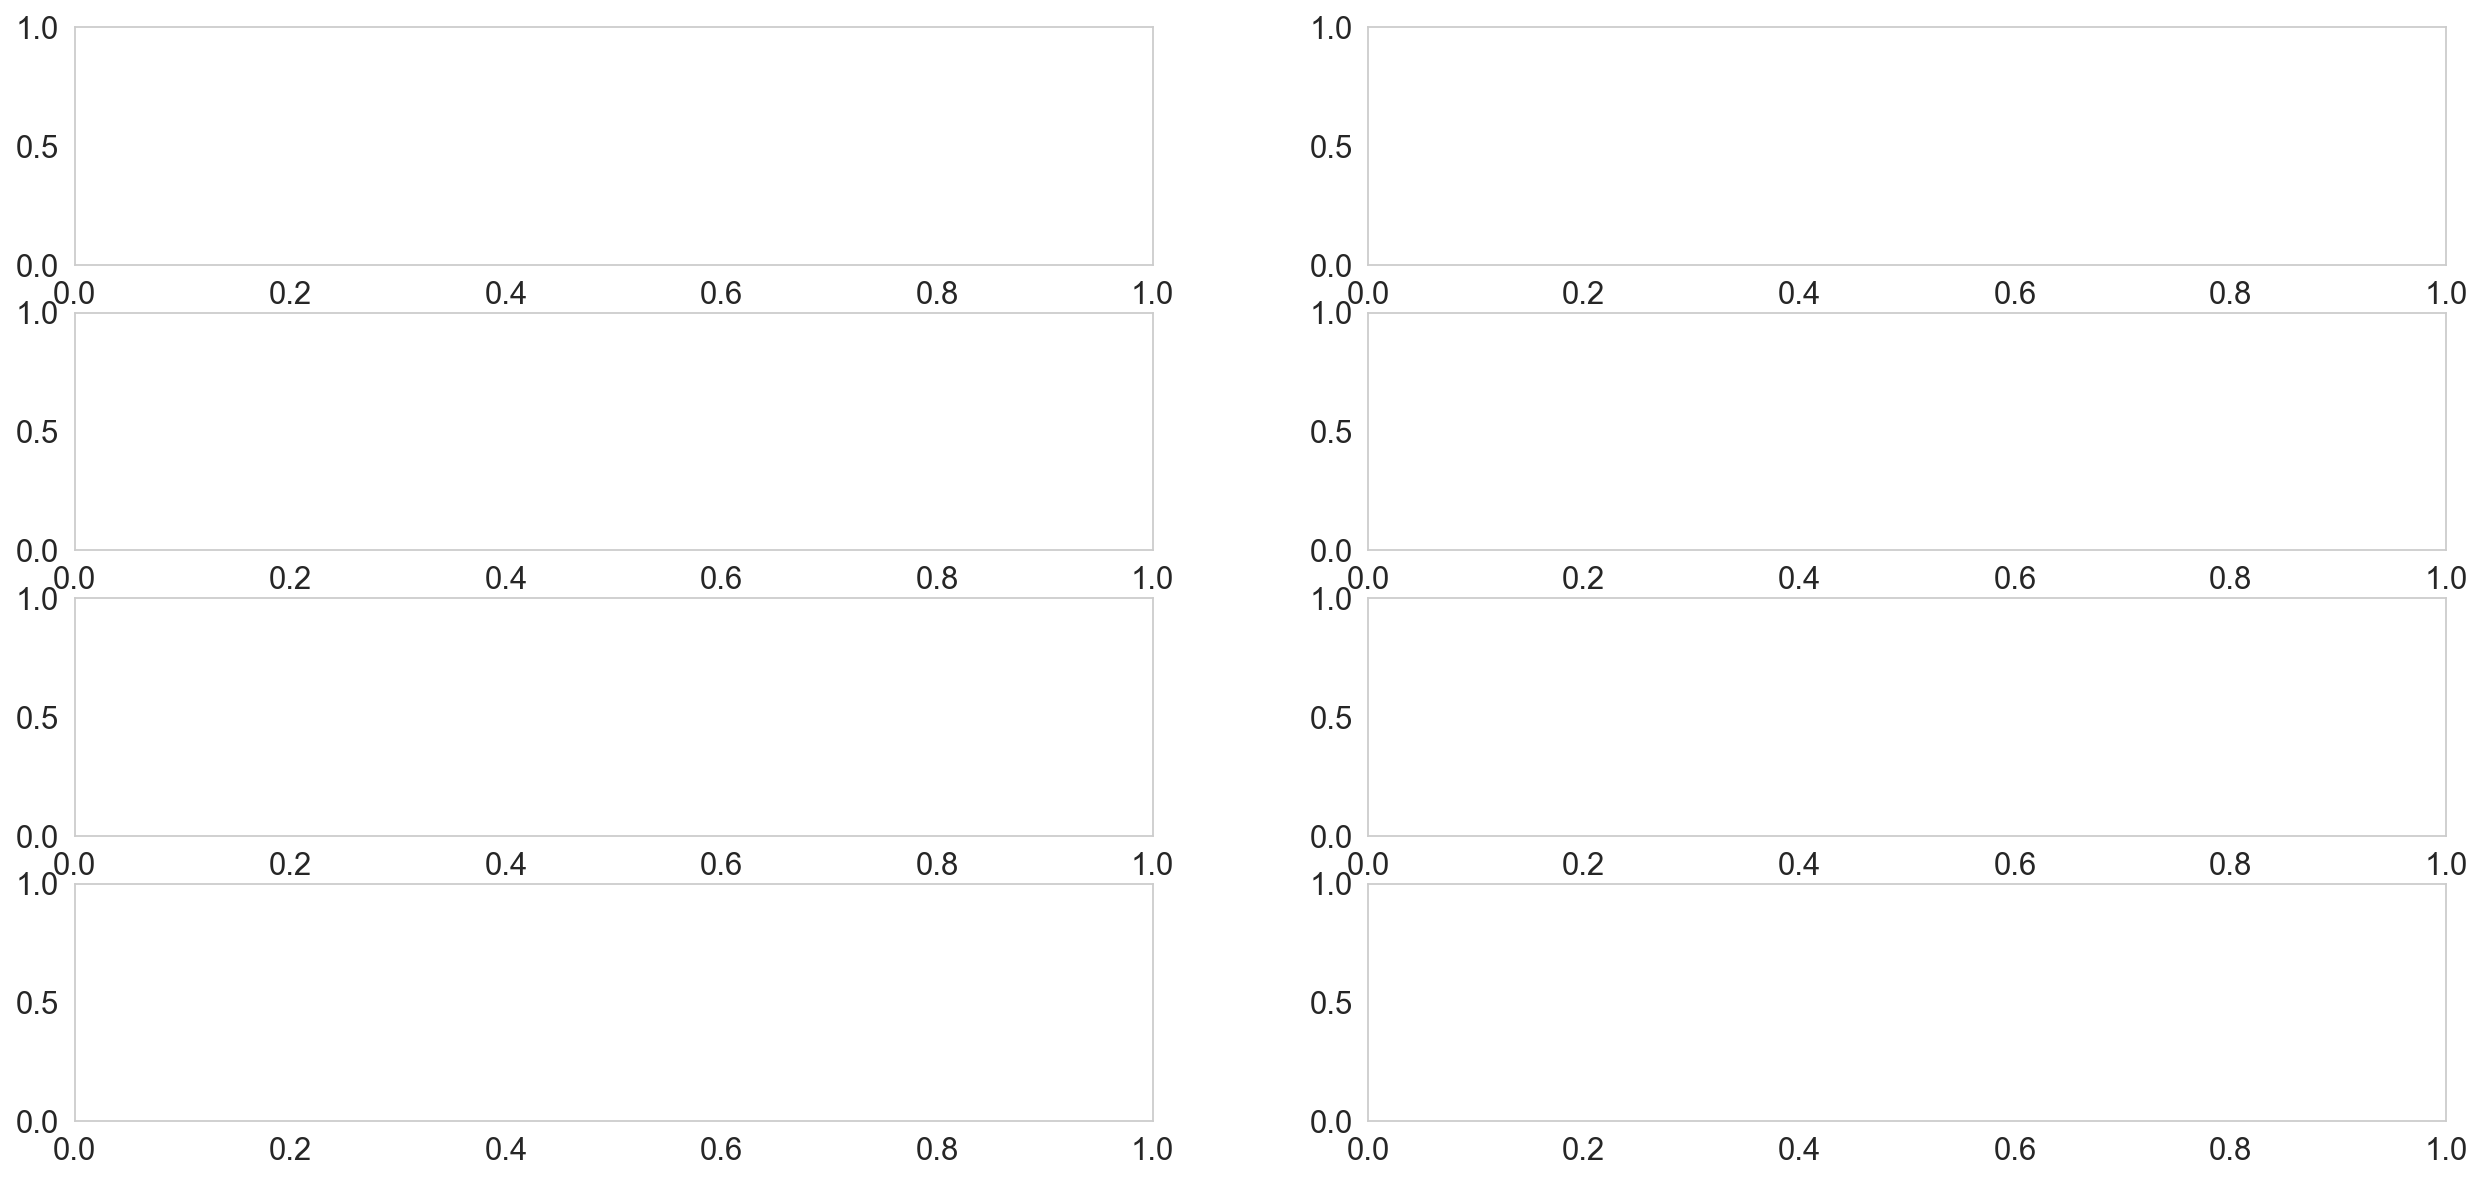

<Figure size 1520x720 with 0 Axes>

In [102]:
plt.rcParams['figure.figsize'] = [19, 9]

plt.rcParams['legend.fontsize'] = 30
plt.rcParams['legend.markerscale'] = 3
plt.rcParams['axes.labelsize'] = 0
plt.rcParams['axes.titlesize'] = 30



sns.set_style("whitegrid", {'axes.grid' : False})


fig, axes = plt.subplots(ncols=2, nrows=4)


for i in adata_m.obs.CellType.cat.categories:

#     plt.xlim(0, 45)
#     plt.ylim(-19,0)

    g = sns.scatterplot(data=adata_batch1[adata_batch1.obs.CellType == i ].obs.groupby('barcode').median(),
                x='X',
                y='Y',
                    
                marker="H",
#                hue='ratio',
                s=1000,
                c=[adata_batch1[adata_batch1.obs.CellType == i].uns['CellType_colors'].item()],
                ax=plt.figure()
               )

    #g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
    #g.set_title(i)
    

In [99]:
adata_m.obs.CellType.cat.categories

Index(['Hepatocyte', 'Kupffer', 'LSEC', 'Lymphocyte', 'MSC', 'Macrophage',
       'mc38'],
      dtype='object')

In [ ]:
#plt.rcParams['figure.figsize'] = [19, 9]

plt.rcParams['legend.fontsize'] = 30
plt.rcParams['legend.markerscale'] = 3
plt.rcParams['axes.labelsize'] = 0
plt.rcParams['axes.titlesize'] = 30



sns.set_style("white", {'axes.grid' : False})

#sns.despine(trim=True)

#fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(9, 6))


for i in adata_m.obs.CellType.cat.categories:

    plt.xlim(0, 45)
    plt.ylim(-19,0)
    
    cell_type_color = adata_batch1[adata_batch1.obs.CellType == i].uns['CellType_colors'].item()
    cell_type_color_map = mpl.colors.LinearSegmentedColormap.from_list("", ["#ffffff",cell_type_color])

    g = sns.scatterplot(data=adata_batch1[adata_batch1.obs.CellType == i].obs.groupby(['barcode','X','Y']).size().reset_index(name="count"),
                x='X',
                y='Y',
                marker="H",
                s=1000,
                hue=adata_batch1[adata_batch1.obs.CellType == i].obs.groupby(['barcode','X','Y']).size().reset_index(name="count")['count'].tolist(),
                palette=cell_type_color_map,
                legend='brief'
                        ###for solid colors:
                #c=[cell_type_color]#[adata_batch1[adata_batch1.obs.CellType == i].uns['CellType_colors'].item()]

               )

    #g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
    g.set_title(i)
    plt.figure()
    